In [ ]:
""" 
Preamble for most code and jupyter notebooks 
@author: bridgetsmart 

@notebook date: 16th Jul 2023 
"""  
import numpy as np, pandas as pd  
import matplotlib.pyplot as plt, seaborn as sns 
import matplotlib as mpl  
import math, string, re, pickle, json, time, os, sys, datetime, itertools  
from tqdm.notebook import tqdm

plt.rcParams["font.family"] = ['Apple SD Gothic Neo', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False # to make - render on xlabels


from functions.cross_correlogram import *
from functions.simulating_hawkes import *

# circadian / time of day effect

from scipy.optimize import curve_fit

import scipy.integrate as integrate


from collections.abc import Iterable

# need a function to flatten irregular list of lists
def flatten(xs):
    for x in xs:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            yield from flatten(x)
        else:
            yield x

In [ ]:
from functions.sinusoidal_jitter_error import get_plots_periodic, jitter_times, bursty,  get_plots_bursty, inactive_bursty

# Understanding the performance of the two approaches
Aim is to create two plots which show the cross-correlogram in the presence of

    (1) Burstiness

    (2) Periodic non-stationary effects

These plots will have four panels which show:

    (1) Homogeneous Poisson null model

    (2) Jittered times

    (3) Inhomogeneous Poisson null model

    (3a) Functional null model (FOR PERIODIC ONLY)


In [3]:
# T = 7*24*60*60 # 1 months
# win = 3*60*60
n_bins_per_unit = 4 # hist bin width is 15 seconds
delta = 1/n_bins_per_unit

# T measured in seconds

T = 30*24 # over 30 days
win = 3 # 3 hours
delta = 0.25 # 15 minutes

target_interval = 6


def lambda_s(x):
    return 30*(np.sin((x)/(24/(2*np.pi))+(18/(np.pi)))+1.07) # period of one day

def lambda_t(x):
    return 30*(np.sin((x)/(24/(2*np.pi))+(14/(np.pi)))+1.07) # period of one day out by a bit


t1_ = gen_poisson_ih(lambda_s, T);
t2_ = gen_poisson_ih(lambda_t, T);

# remove 0.5 of the data
t1 = t1_#[np.random.rand(len(t1_))>0.9]
t2 = t2_#[np.random.rand(len(t2_))>0.9]

## now add some events to t2 which are from t1 with a small delay
# to_add = np.random.choice(t1, size = len(t1)//10) + 60*60*0.5*np.random.rand(len(t1)//10) + 60*60
# t2 = np.concatenate([t2,to_add])

## sort t2
# t2 = np.sort(t2)


t1 = np.array(t1)
t2 = np.array(t2)

### generate all the jittered time series
tjquarter_target = np.array(jitter_times(t2, 3, 0, T))
tjhalf_target = np.array(jitter_times(t2, 6, 0, T))
tjone_target = np.array(jitter_times(t2, 12, 0, T))
tjtwo_target = np.array(jitter_times(t2, 24, 0, T))

tjquarter_source= np.array(jitter_times(t1, 3, 0, T))
tjhalf_source= np.array(jitter_times(t1, 6, 0, T))
tjone_source= np.array(jitter_times(t1, 12, 0, T))
tjtwo_source= np.array(jitter_times(t1, 24, 0, T))


tj_target = [tjquarter_target, tjhalf_target, tjone_target, tjtwo_target]
tj_source = [tjquarter_source, tjhalf_source, tjhalf_source, tjtwo_source]

print(f'Lengths {len(t1), len(t2), [len(x) for x in tj_source], [len(x) for x in tj_target]}')

Lengths (23080, 23394, [23080, 23080, 23080, 23080], [23394, 23394, 23394, 23394])


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/bridgetsmart/Documents/Python/HashtagDynamics/TOD Effect/sinusoidal_jitter_error.py:53: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(term, w, T-w)[0] # integral from si+hj to si+hj+delta of lambda_S * E[events from T]
/Users/bridgetsmart/Documents/Python/HashtagDynamics/TOD Effect/sinusoidal_jitter_error.py:53: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local diff

True

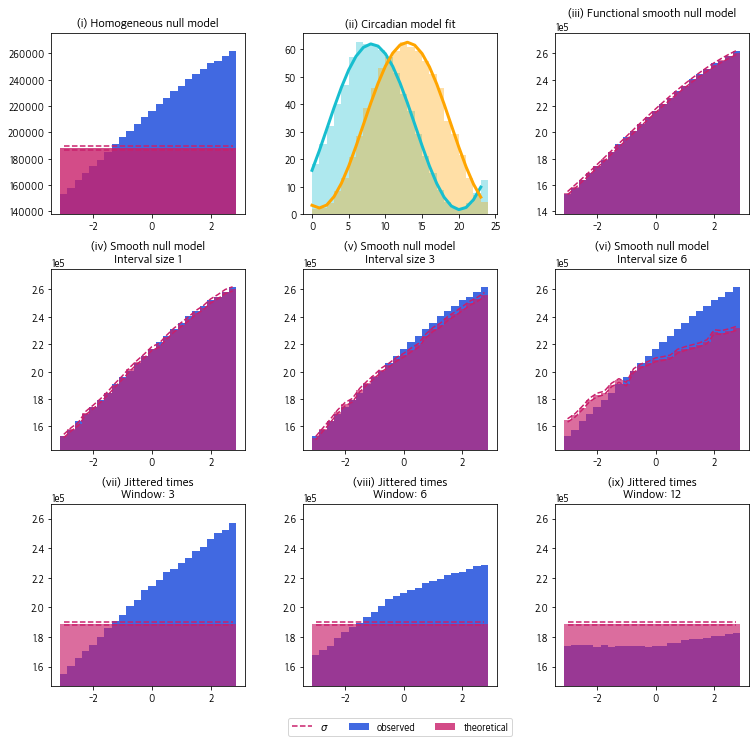

In [4]:
get_plots_periodic(t1,t2,tj_target, tj_source,3,0.25,[1,3,6],[3,6,12],T)

## simulate bursty data

In [9]:

from collections import Counter

def get_new_time(expected_time):
    # generate time between poisson events given the rate.
    # expected time = rate (expected time between events)

    return np.random.exponential(expected_time)


def sim_ct(rates, t_finish, t_current, current_state = 0):
    # simulating c(t) for a single process
    # c(t) is the underlying markov process which 
    # describes if a process is currently coordinating
    # or not.

    # rates = vector giving 
    #   [expected time to move into coordinated state,
    #    expected time to move into a non coordinated state]

    # t_finish = time to simulate events until
    # t_current = time to simulate events from

    # current_state = 0 # non coord is default

    transition_times = []
    t_dash = get_new_time(rates[current_state])
    t_current += t_dash
    current_state = np.mod(current_state+1,2)
    # generate exponential random variable with rate 1/to_coord
    while t_current<t_finish:
        transition_times.append(t_current)
        t_dash = get_new_time(rates[current_state])

        t_current += t_dash
        current_state = np.mod(current_state+1,2)


    return [k for k,v in Counter(transition_times).items() if v==1] # dict preserves order


In [16]:

n_bins_per_unit = 4 # hist bin width is 15 seconds
delta = 1/n_bins_per_unit

win = 10

c1 = 100
c2 = 100 # 1 event per minute

int_l = 0.02 # around 10 seconds
int_u = 5/60 # around 30 seconds

BR = 0.8 # quite high

T = 1400

lambda_s_bursty = lambda t: c1
lambda_t_bursty = lambda t: c2

c_t =  sim_ct((50,20), T, 0, current_state = 0) # expect to spend 50 units in a independent state and then 20 in bursty

t1 = inactive_bursty(lambda_s_bursty, BR, int_l, int_u, T, c_t)
t2 = inactive_bursty(lambda_t_bursty, BR, int_l, int_u, T, c_t)


t1 = np.array(t1)
t2 = np.array(t2)

### generate all the jittered time series
jitter_intervals = [24, 6, 12, 48]

tjquarter_target = np.array(jitter_times(t2, jitter_intervals[0], 0, T))
tjhalf_target = np.array(jitter_times(t2, jitter_intervals[1], 0, T))
tjone_target = np.array(jitter_times(t2, jitter_intervals[2], 0, T))
tjtwo_target = np.array(jitter_times(t2, jitter_intervals[3], 0, T))

tjquarter_source= np.array(jitter_times(t1, jitter_intervals[0], 0, T))
tjhalf_source= np.array(jitter_times(t1, jitter_intervals[1], 0, T))
tjone_source= np.array(jitter_times(t1, jitter_intervals[2], 0, T))
tjtwo_source= np.array(jitter_times(t1, jitter_intervals[3], 0, T))


tj_target = [tjquarter_target, tjhalf_target, tjone_target, tjtwo_target]
tj_source = [tjquarter_source, tjhalf_source, tjhalf_source, tjtwo_source]

print(f'Lengths {len(t1), len(t2), [len(x) for x in tj_source], [len(x) for x in tj_target]}')

Lengths (104363, 104951, [104363, 104363, 104363, 104363], [104951, 104951, 104951, 104951])


[24, 6, 12, 48]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:02<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/bridgetsmart/Documents/Python/HashtagDynamics/TOD Effect/sinusoidal_jitter_error.py:53: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(term, w, T-w)[0] # integral from si+hj to si+hj+delta of lambda_S * E[events from T]
/Users/bridgetsmart/Documents/Python/HashtagDynamics/TOD Effect/sinusoidal_jitter_error.py:53: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local diff

True

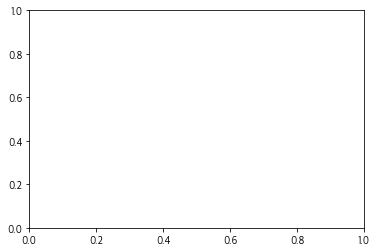

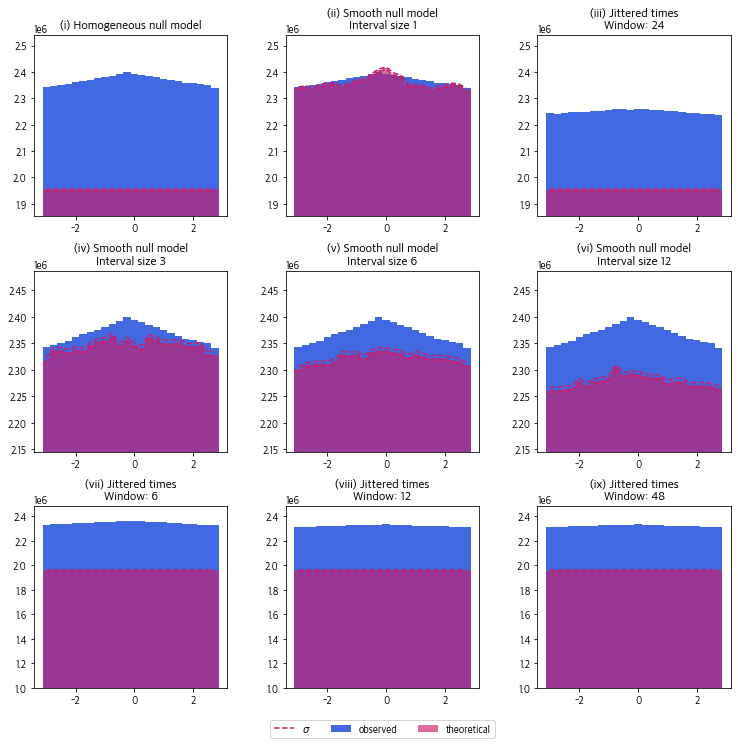

In [17]:
get_plots_bursty(t1,t2,tj_target, tj_source,3,0.25,[1,3,6,12],jitter_intervals,T)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:03<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/bridgetsmart/Documents/Python/HashtagDynamics/TOD Effect/sinusoidal_jitter_error.py:45: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(term, w, T-w)[0] # integral from si+hj to si+hj+delta of lambda_S * E[events from T]
/Users/bridgetsmart/Documents/Python/HashtagDynamics/TOD Effect/sinusoidal_jitter_error.py:45: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local diff

True

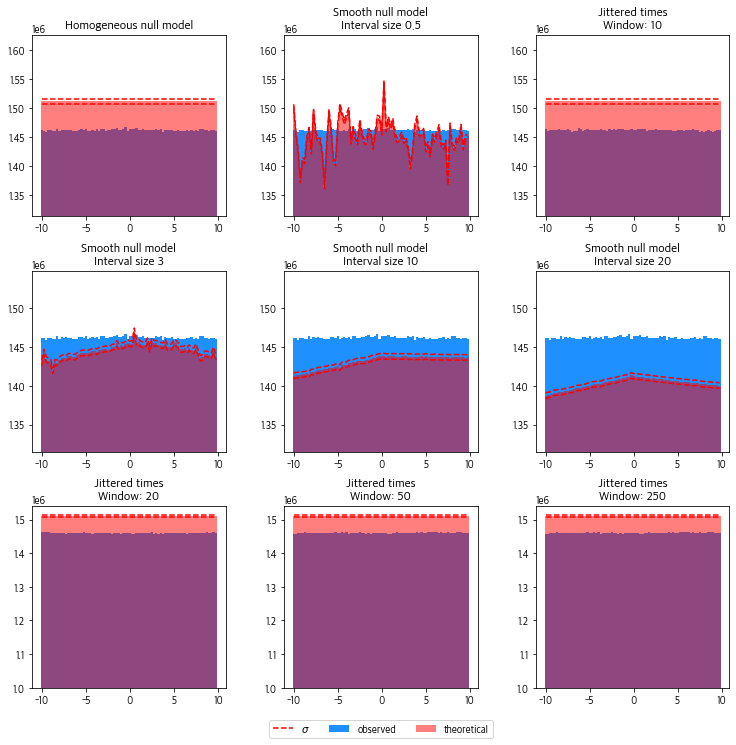

In [8]:
get_plots_bursty(t1,t2,tj_target, tj_source, win, delta, [0.5,3,10,20], jitter_intervals, T)

# Error with sinusoidal function

In this section we are interested in how error increases with functions of periodicity (in particular period and amplitude).

In [3]:
def expected_target_events_hj_delta(si, hj, delta, lambda_T):
    l= si + hj
    return integrate.quad(lambda_T, l, l+delta)[0] # integral from si+hj to si+hj+delta of lambda_T

def expected_bin_height(hj, lambda_S, lambda_T, delta, w, T):
    term = lambda x : lambda_S(x) * expected_target_events_hj_delta(x, hj, delta, lambda_T)
    return integrate.quad(term, w, T-w)[0] # integral from si+hj to si+hj+delta of lambda_S * E[events from T]

def sd_bin_height(hj, lambda_S, lambda_T, delta, w, T):
    term = lambda x : lambda_S(x) * expected_target_events_hj_delta(x, hj, delta, lambda_T)
    return integrate.quad(term, w, T-w)[0] # integral from si+hj to si+hj+delta of lambda_S * E[events from T]

In [19]:

## simulation to test error in mean averaging


c1 = 6 # 1 event per minute
c2 = 6

A = 0.3 # amplitude of the target intensity
b = 24 # period of the target intensity
d = 0 # phase shift of the target intensity

T = 1000
# source intensity
lambda_s = lambda t: c1

# target intensity
lambda_t = lambda t: c2 + A * math.sin( (t-d) * (2 * math.pi) / b)

delta = 0.25 # bin size of 15 minutes
win = 3

factor_red = 10

A_max = 60

norm_errors_A = []
A_s = []

bins= np.arange(-win,win+delta,delta)
to_zero = np.where((bins == -delta))[0][0], np.where(bins==0)[0][0]

### SAMPLING
for A in tqdm(np.arange(1,A_max,1)):
    A_s.append(A)
    # target intensity
    lambda_t = lambda t: c2 + A * math.sin( (t-d) * (2 * math.pi) / b)

    t1 = np.array(gen_poisson_ih(lambda_s, T))
    t2 = np.array(gen_poisson_ih(lambda_t, T))

    # get expected bin heights for source and target intensities WITH and WITHOUT jitter
    true_bin_heights = np.array([expected_bin_height(x, lambda_s, lambda_t, delta, win, T) for x in left_bin_edges(win, delta)])

    deltas = []
    for t in np.array_split(t1, factor_red): # auspol occurs 3.6 times more than the second most frequent - this is a safe value
        deltas.append(possible_time_del(t, t2, win, T))

    deltas = np.array(list(flatten(deltas)))


    H, bins = np.histogram(deltas, bins= np.arange(-win,win+delta,delta))

    for ind in to_zero:
        H[ind] = 0
        true_bin_heights[ind]=0

    norm_errors_A.append(np.abs((true_bin_heights - H)) / true_bin_heights)

    

  0%|          | 0/59 [00:00<?, ?it/s]

/var/folders/wp/758jq81s3hs0jlp8_31261sc0000gn/T/ipykernel_61921/1319225967.py:56: RuntimeWarning: invalid value encountered in true_divide
  norm_errors_A.append(np.abs((true_bin_heights - H)) / true_bin_heights)


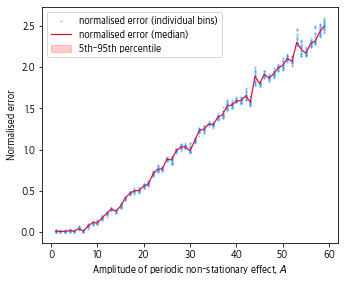

In [65]:
# scatter plot of normalised errors for each value of k, removing any inf values where norm error is a list of errors for each value of k

# replace any inf values with 0
norm_errors_A = np.array(norm_errors_A)
norm_errors_A[norm_errors_A == np.inf] = 0

# plot all errors for each value of k
plt.figure(figsize=[5.3, 4.34])
sns.scatterplot(x=np.repeat(A_s, len(norm_errors_A[0])), y=norm_errors_A.flatten(), s=4, alpha=0.5, label='normalised error (individual bins)',color='dodgerblue')
# plt.title('Normalised error as a function of A')

# # line plot of mean normalised error for each value of k
sns.lineplot(x=A_s, y=np.nanmedian(norm_errors_A, axis=1), c='crimson',label='normalised error (median)', linewidth=1.25)

# # ci for each value of k using 25th and 75th percentiles
plt.fill_between(A_s, np.percentile(norm_errors_A, 5, axis=1), np.percentile(norm_errors_A, 95, axis=1), alpha=0.2, color='r', label = '5th-95th percentile')

# add legend and move to bottom of chart below the x-axis
legend = plt.legend(loc='upper left', shadow=False, ncol=1)
# legend.legendHandles[0]._sizes = np.array([7.5])
# # set alpha
# legend.legendHandles[0].set_alpha(1) 


# axis labels
plt.xlabel(r'Amplitude of periodic non-stationary effect, $A$')
plt.ylabel('Normalised error')
plt.savefig('periodic_amp_error.pdf',  bbox_inches='tight')

In [26]:
b_max = 100 # maximum period
A = 10
b_s = []
norm_errors_b = []

### SAMPLING
for b in tqdm(np.arange(1,b_max+1,0.5)):

    b_s.append(b)
    # target intensity
    lambda_t = lambda t: c2 + A * math.sin( (t-d) * (2 * math.pi) / b)

    t1 = gen_poisson_ih(lambda_s, T)
    t2 = gen_poisson_ih(lambda_t, T)

    # get expected bin heights for source and target intensities WITH and WITHOUT jitter
    true_bin_heights = np.array([expected_bin_height(x, lambda_s, lambda_t, delta, win, T) for x in left_bin_edges(win, delta)])

    deltas = []
    for t in np.array_split(t1, factor_red): # auspol occurs 3.6 times more than the second most frequent - this is a safe value
        deltas.append(possible_time_del(t, t2, win, T))

    deltas = np.array(list(flatten(deltas)))

    H, bins = np.histogram(deltas, bins= np.arange(-win,win+delta,delta))

    for ind in to_zero:
        H[ind] = 0
        true_bin_heights[ind]=0

    norm_errors_b.append(np.abs((true_bin_heights - H)) / true_bin_heights)

  0%|          | 0/200 [00:00<?, ?it/s]

/var/folders/wp/758jq81s3hs0jlp8_31261sc0000gn/T/ipykernel_61921/1825743218.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(term, w, T-w)[0] # integral from si+hj to si+hj+delta of lambda_S * E[events from T]
/var/folders/wp/758jq81s3hs0jlp8_31261sc0000gn/T/ipykernel_61921/4146035644.py:31: RuntimeWarning: invalid value encountered in true_divide
  norm_errors_b.append(np.abs((true_bin_heights - H)) / true_bin_heights)


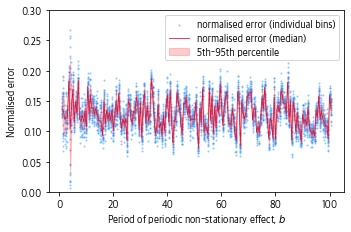

In [64]:
# scatter plot of normalised errors for each value of k, removing any inf values where norm error is a list of errors for each value of k

# replace any inf values with 0
norm_errors_b = np.array(norm_errors_b)
norm_errors_b[norm_errors_b == np.inf] = 0

# plot all errors for each value of k
plt.figure(figsize=[5.3, 4.34])
sns.scatterplot(x=np.repeat(b_s, len(norm_errors_b[0])), y=norm_errors_b.flatten(), s=4, alpha=0.5,  label='normalised error (individual bins)',color='dodgerblue')
# plt.title('Normalised error as a function of b')

# line plot of mean normalised error for each value of k
sns.lineplot(x=b_s, y=np.nanmedian(norm_errors_b, axis=1), c='crimson', label='normalised error (median)', linewidth=0.8)

# # ci for each value of k using 25th and 75th percentiles
plt.fill_between(b_s, np.nanpercentile(norm_errors_b, 25, axis=1), np.nanpercentile(norm_errors_b, 75, axis=1), alpha=0.2, color='r',label = '5th-95th percentile')

legend = plt.legend(loc='upper right', shadow=False, ncol=1)
# legend.legendHandles[0]._sizes = np.array([7.5])
# # set alpha
# legend.legendHandles[0].set_alpha(1) 
plt.ylim(0,0.3)

# axis labels
plt.xlabel(r'Period of periodic non-stationary effect, $b$')
plt.ylabel('Normalised error')
plt.savefig('periodic_period_error.pdf',  bbox_inches='tight')

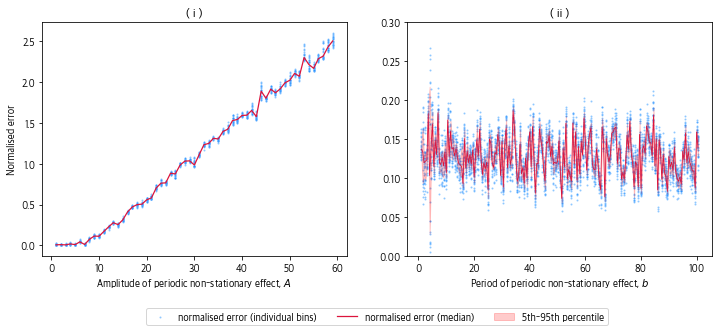

In [81]:
# as subplots

fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(12,4.3))
axs = axs.ravel()

# subplot i
axs[0].set_title('( i )')
# replace any inf values with 0
norm_errors_A = np.array(norm_errors_A)
norm_errors_A[norm_errors_A == np.inf] = 0

# plot all errors for each value of k
sns.scatterplot(x=np.repeat(A_s, len(norm_errors_A[0])), y=norm_errors_A.flatten(), s=4, alpha=0.5, label='normalised error (individual bins)',color='dodgerblue', ax=axs[0])
# plt.title('Normalised error as a function of A')

# # line plot of mean normalised error for each value of k
sns.lineplot(x=A_s, y=np.nanmedian(norm_errors_A, axis=1), c='crimson',label='normalised error (median)', linewidth=1.25, ax=axs[0])

# # ci for each value of k using 25th and 75th percentiles
axs[0].fill_between(A_s, np.percentile(norm_errors_A, 5, axis=1), np.percentile(norm_errors_A, 95, axis=1), alpha=0.2, color='r', label = '5th-95th percentile')
# axis labels
axs[0].set_xlabel(r'Amplitude of periodic non-stationary effect, $A$')
axs[0].set_ylabel('Normalised error')
axs[0].legend(loc='upper center', bbox_to_anchor=(1.1, -.2), shadow=False, ncol=3)

# subplot 2
axs[1].set_title('( ii )')

# scatter plot of normalised errors for each value of k, removing any inf values where norm error is a list of errors for each value of k

# replace any inf values with 0
norm_errors_b = np.array(norm_errors_b)
norm_errors_b[norm_errors_b == np.inf] = 0

# plot all errors for each value of k
sns.scatterplot(x=np.repeat(b_s, len(norm_errors_b[0])), y=norm_errors_b.flatten(), s=4, alpha=0.5, color='dodgerblue', ax=axs[1])
# plt.title('Normalised error as a function of b')

# line plot of mean normalised error for each value of k
sns.lineplot(x=b_s, y=np.nanmedian(norm_errors_b, axis=1), c='crimson', linewidth=0.8, ax=axs[1])

# # ci for each value of k using 25th and 75th percentiles
axs[1].fill_between(b_s, np.nanpercentile(norm_errors_b, 25, axis=1), np.nanpercentile(norm_errors_b, 75, axis=1), alpha=0.2, color='r')

# legend.legendHandles[0]._sizes = np.array([7.5])
# # set alpha
# legend.legendHandles[0].set_alpha(1) 
axs[1].set_ylim(0,0.3)

# axis labels
axs[1].set_xlabel(r'Period of periodic non-stationary effect, $b$')
# axs[1].set_ylabel('Normalised error')
plt.savefig('combined_periodic_error.pdf',  bbox_inches='tight')

In [ ]:
## jitter error as function of BR



In [39]:
from simulating_hawkes import gen_poisson_homogeneous_single

In [40]:
# set up simulations for burstyness based on the spivakDeconvolutionImprovesDetection2022 paper

BR = 0.2 # this is the probability that an event is followed ny another spike within a uniform time interval of (l,u)
int_l = 1
int_u = 10

def bursty(lambda_t, BR, int_l, int_u, T):
    t_current = 0
    times = []
    while t_current < T:

        t_n = gen_poisson_homogeneous_single(lambda_t(t_current))
        t_current += t_n

        times = add_new_time(t_current, times, lambda_t, BR, int_l, int_u, T)

        t_current = times[-1]
    
    return times


def add_new_time(t_current, times, lambda_t, BR, int_l, int_u, T):

    times.append(t_current + gen_poisson_homogeneous_single(lambda_t(t_current)))

    u = np.random.rand()
    while u < BR:
        times.append(t_current + np.random.uniform(int_l, int_u))
        t_current = times[-1]
        u = np.random.rand()

        if t_current >= T:
            return times
        
    return times

In [41]:
def get_observed_bins(source,target,win,T,delta):
    '''
    delta = width of hist bin

    '''
    if type(source) == list:
        source = np.array(source)
    if type(target)==list:
        target = np.array(target)

    bins= np.arange(-win,win+delta,delta)
    to_zero = np.where((bins == -delta))[0][0], np.where(bins==0)[0][0]

    deltas = possible_time_del(source,target,win,T)
    # print('ob deltas')
    H, bins = np.histogram(deltas, bins= np.arange(-win,win+delta,delta))

    for ind in to_zero:
        H[ind] = 0

    return H

In [7]:
# sample intensity functions are both constant with burstyness
c1 = 1
c2 = 1

T = 1000

lambda_s_bursty = lambda t: c1
lambda_t_bursty = lambda t: c2

In [42]:
# look at error as a function of k

## PARAMETERS
c1 = 1
c2 = 1

int_l = 1
int_u = 10
jitter_interval=50

T = 1000

lambda_s_bursty = lambda t: c1
lambda_t_bursty = lambda t: c2

n_iter = 100

Delta = 0.25 # bin size of 15 minutes
w= 6 # width of cross correlogram (i.e. 3 hours)

# get expected bin heights for source and target intensities WITHOUT jitter
bins = np.arange(-w,w+Delta,Delta)

errors_BR = []
norm_errors_BR = []
BR_s = []
### SAMPLING
for BR in tqdm(np.arange(0,1,0.01)):
    for _ in range(n_iter):
        BR_s.append(BR)

        delta = jitter_interval * Delta
        
        t1 = np.array(bursty(lambda_t_bursty, BR, int_l, int_u, T))
        t2 = np.array(bursty(lambda_s_bursty, BR, int_l, int_u, T))
        t1_jitter = np.array(jitter_times(t1, jitter_interval, 0, T))
        t2_jitter = np.array(jitter_times(t2, jitter_interval, 0, T))

        observed_bin_heights_og = get_observed_bins(t1,t2,w,T,Delta) 
        # match the zeroing around 0
        jitt_bin_heights = get_observed_bins(t1_jitter, t2_jitter,w,T,Delta) 

        errors_BR.append(np.sum((observed_bin_heights_og - jitt_bin_heights)**2))
        norm_errors_BR.append(np.abs((observed_bin_heights_og - jitt_bin_heights)) / observed_bin_heights_og)


  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/wp/758jq81s3hs0jlp8_31261sc0000gn/T/ipykernel_84360/192004167.py:44: RuntimeWarning: invalid value encountered in true_divide
  norm_errors_BR.append(np.abs((observed_bin_heights_og - jitt_bin_heights)) / observed_bin_heights_og)
/var/folders/wp/758jq81s3hs0jlp8_31261sc0000gn/T/ipykernel_84360/192004167.py:44: RuntimeWarning: divide by zero encountered in true_divide
  norm_errors_BR.append(np.abs((observed_bin_heights_og - jitt_bin_heights)) / observed_bin_heights_og)


In [43]:
BR_s_norm_all = [BR_s[i] for i in range(len(BR_s)) for _ in range(len(norm_errors_BR[i]))]

/var/folders/wp/758jq81s3hs0jlp8_31261sc0000gn/T/ipykernel_84360/1803169094.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0]._sizes = np.array([7.5])
/var/folders/wp/758jq81s3hs0jlp8_31261sc0000gn/T/ipykernel_84360/1803169094.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0].set_alpha(1)


Text(0, 0.5, 'Relative error')

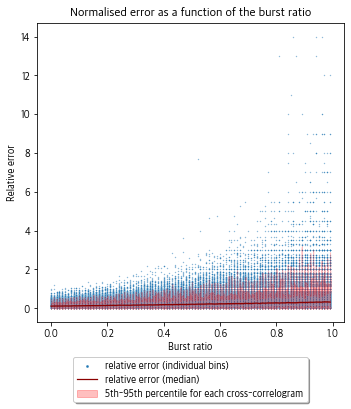

In [44]:
# scatter plot of normalised errors for each value of k, removing any inf values where norm error is a list of errors for each value of k

# replace any inf values with 0
norm_errors_BR = np.array(norm_errors_BR)
norm_errors_BR[norm_errors_BR == np.inf] = 0


# plot all errors for each value of k
plt.figure(figsize=(5.5,5.5))
sns.scatterplot(x=np.repeat(BR_s, len(norm_errors_BR[0])), y=norm_errors_BR.flatten(), s=2, alpha=0.5, label='relative error (individual bins)')
plt.title('Normalised error as a function of the burst ratio')

# line plot of mean normalised error for each value of k
sns.lineplot(x=BR_s, y=np.nanmedian(norm_errors_BR, axis=1), c='darkred', label='relative error (median)', linewidth=1.25)

# ci for each value of k using 25th and 75th percentiles
plt.fill_between(BR_s, np.nanpercentile(norm_errors_BR, 5, axis=1), np.nanpercentile(norm_errors_BR, 95, axis=1), alpha=0.25, color='r', label = '5th-95th percentile for each cross-correlogram')

# make scatterpoint in the legend larger

# add legend and move to bottom of chart below the x-axis
legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=1)
legend.legendHandles[0]._sizes = np.array([7.5])
# set alpha
legend.legendHandles[0].set_alpha(1) 


# axis labels
plt.xlabel('Burst ratio')
plt.ylabel('Relative error')


In [8]:
# my functions
import numpy as np, pandas as pd

import matplotlib.pyplot as plt, seaborn as sns
import matplotlib as mpl

import math, string, re, pickle, json, time, os, sys, datetime, itertools

from collections import Counter

import networkx as nx
import scipy
import bisect
from numpy.random import default_rng

def get_new_time(expected_time):
    # generate time between poisson events given the rate.
    # expected time = rate (expected time between events)

    return np.random.exponential(expected_time)


def sim_ct(rates, t_finish, t_current, current_state = 0):
    # simulating c(t) for a single process
    # c(t) is the underlying markov process which 
    # describes if a process is currently coordinating
    # or not.

    # rates = vector giving 
    #   [expected time to move into coordinated state,
    #    expected time to move into a non coordinated state]

    # t_finish = time to simulate events until
    # t_current = time to simulate events from

    # current_state = 0 # non coord is default

    transition_times = []
    t_dash = get_new_time(rates[current_state])
    t_current += t_dash
    current_state = np.mod(current_state+1,2)
    # generate exponential random variable with rate 1/to_coord
    while t_current<t_finish:
        transition_times.append(t_current)
        t_dash = get_new_time(rates[current_state])

        t_current += t_dash
        current_state = np.mod(current_state+1,2)


    return [k for k,v in Counter(transition_times).items() if v==1] # dict preserves order


def get_current_state(c_t, current_time):
    #### Modified ####
    # returns 0 if not coordinating
    # returns 1 otherwise
    ind_test = bisect.bisect_left(c_t, current_time)
    if ind_test == len(c_t):
        return np.mod(ind_test,2), False
    else:
        return np.mod(ind_test,2), c_t[ind_test]
from simulating_hawkes import gen_poisson_homogeneous_single
# set up simulations for burstyness based on the spivakDeconvolutionImprovesDetection2022 paper


def inactive_bursty_test(lambda_t, BR, int_l, int_u, T, c_t):
    t_current = 0
    times = []
    types_times = []
    while t_current < T:

        t_n = gen_poisson_homogeneous_single(lambda_t(t_current))
        t_current += t_n

        times, types_times = add_new_time_test(t_current, times, lambda_t, BR, int_l, int_u, T, c_t, types_times)
        t_current = times[-1]
    
    return times, types_times


def add_new_time_test(t_current, times, lambda_t, BR, int_l, int_u, T, c_t, types_times):

    times.append(t_current )
    types_times.append(0)
    
    u = np.random.rand()
    active_bursty, _ = get_current_state(c_t, times[-1])

    while (u < BR) and (active_bursty==1):
        times.append(t_current + np.random.uniform(int_l, int_u))
        types_times.append(1)
        t_current = times[-1]

        active_bursty, _ = get_current_state(c_t, times[-1])
        u = np.random.rand()

        if t_current >= T:
            return times, types_times
        
    return times, types_times
# set up simulations for burstyness based on the spivakDeconvolutionImprovesDetection2022 paper



def inactive_bursty(lambda_t, BR, int_l, int_u, T, c_t):
    t_current = 0
    times = []
    while t_current < T:

        t_n = gen_poisson_homogeneous_single(lambda_t(t_current))
        t_current += t_n

        times = add_new_time(t_current, times, lambda_t, BR, int_l, int_u, T, c_t)

        t_current = times[-1]
    
    return times


def add_new_time(t_current, times, lambda_t, BR, int_l, int_u, T, c_t):

    times.append(t_current )

    
    u = np.random.rand()
    active_bursty, _ = get_current_state(c_t, times[-1])

    while (u < BR) and (active_bursty==1):
        times.append(t_current + np.random.uniform(int_l, int_u))
        t_current = times[-1]

        active_bursty, _ = get_current_state(c_t, times[-1])
        u = np.random.rand()

        if t_current >= T:
            return times
        
    return times
def get_observed_bins(source,target,win,T,delta):
    '''
    delta = width of hist bin

    '''
    if type(source) == list:
        source = np.array(source)
    if type(target)==list:
        target = np.array(target)

    bins= np.arange(-win,win+delta,delta)
    to_zero = np.where((bins == -delta))[0][0], np.where(bins==0)[0][0]

    deltas = possible_time_del(source,target,win,T)
    # print('ob deltas')
    H, bins = np.histogram(deltas, bins= np.arange(-win,win+delta,delta))

    for ind in to_zero:
        H[ind] = 0

    return H
from cross_correlogram import *
from simulating_hawkes import *

# circadian / time of day effect

from scipy.optimize import curve_fit

import scipy.integrate as integrate
def expected_target_events_hj_delta(si, hj, delta, lambda_T):
    l= si + hj
    return integrate.quad(lambda_T, l, l+delta)[0] # integral from si+hj to si+hj+delta of lambda_T

def expected_bin_height(hj, lambda_S, lambda_T, delta, w, T):
    term = lambda x : lambda_S(x) * expected_target_events_hj_delta(x, hj, delta, lambda_T)
    return integrate.quad(term, w, T-w)[0] # integral from si+hj to si+hj+delta of lambda_S * E[events from T]

def sd_bin_height(hj, lambda_S, lambda_T, delta, w, T):
    term = lambda x : lambda_S(x) * expected_target_events_hj_delta(x, hj, delta, lambda_T)
    return integrate.quad(term, w, T-w)[0] # integral from si+hj to si+hj+delta of lambda_S * E[events from T]
def exp_bin_heighed_jittered(x, lambda_s, lambda_t_jittered, Delta, w, T,jitter_intervals):
    start = w
    end = T-w

    s = 0

    # get index of first jitter interval bigger than start
    i_start = np.where(jitter_intervals >= start)[0][0]    
    i_end = np.where(jitter_intervals >= (T-w))[0][0] -1

    for i in range(i_start, i_end):
        s += expected_bin_height(x, lambda_s, lambda_t_jittered, Delta, jitter_intervals[i] + 1e-6, jitter_intervals[i+1]- 1e-6) 

    if (T-w) > jitter_intervals[i_end]:
        s += expected_bin_height(x, lambda_s, lambda_t_jittered, Delta, jitter_intervals[i_end]+ 1e-6, T-w)

    return s

In [24]:
observed_bin_heights_og = get_observed_bins(t1,t2,w,T,Delta) 

In [36]:

## PARAMETERS
c1 = 2
c2 = 2

int_l = 1
int_u = 5
Delta = 0.25 # bin size of 15 minutes

T = 1000

lambda_s_bursty = lambda t: c1
lambda_t_bursty = lambda t: c2

n_iter = 100

w = 10
jitter_interval = 10

# get expected bin heights for source and target intensities WITHOUT jitter
bins = np.arange(-w,w+Delta,Delta)

errors_BR_inactive = []
norm_errors_BR_inactive = []
BR = 0.8

k = 12
bursty_states_ = []
non_bursty_states_ = []
r_max = 40
### SAMPLING

for r1 in tqdm(np.arange(1,r_max)):
    for r2 in tqdm(np.arange(1,r_max)):
        for _ in range(n_iter):
            non_bursty_states_.append(r1)
            bursty_states_.append(r2)

            delta = k * Delta

            c_t = sim_ct((r1,r2), T, 0, current_state = 0)
            t1 = np.array(inactive_bursty(lambda_t_bursty, BR, int_l, int_u, T, c_t))
            t2 = np.array(inactive_bursty(lambda_s_bursty, BR, int_l, int_u, T, [])) # no bursty in source

            t1_jitter = np.array(jitter_times(t1, jitter_interval, 0, T))
            t2_jitter = np.array(jitter_times(t2, jitter_interval, 0, T))

            observed_bin_heights_og = get_observed_bins(t1,t2,w,T,Delta) 
            # match the zeroing around 0
            jitt_bin_heights = get_observed_bins(t1_jitter, t2_jitter,w,T,Delta) 

            errors_BR_inactive.append(np.sum((observed_bin_heights_og - jitt_bin_heights)**2))
            norm_errors_BR_inactive.append(np.abs((observed_bin_heights_og - jitt_bin_heights)) / observed_bin_heights_og)


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

/var/folders/wp/758jq81s3hs0jlp8_31261sc0000gn/T/ipykernel_84360/662804173.py:52: RuntimeWarning: invalid value encountered in true_divide
  norm_errors_BR_inactive.append(np.abs((observed_bin_heights_og - jitt_bin_heights)) / observed_bin_heights_og)


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Text(0, 0.5, 'Time in non-bursty state')

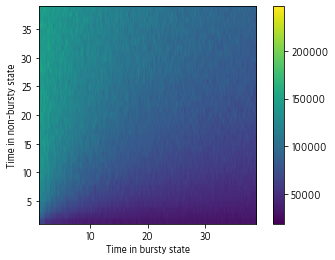

In [37]:
norm_errors_BR_all_inactive = np.array(norm_errors_BR_inactive)

# convert all to numpy arrays
non_bursty_states_ = np.array(non_bursty_states_)
bursty_states_ = np.array(bursty_states_)
errors_BR_inactive = np.array(errors_BR_inactive)
norm_errors_BR_inactive = np.nanmedian(norm_errors_BR_all_inactive, axis=1)
norm_errors_BR_var = np.nanvar(norm_errors_BR_all_inactive, axis=1)

non_bursty_states_.reshape(len(np.arange(1,r_max)),-1)
bursty_states_.reshape(len(np.arange(1,r_max)),-1)
zs = errors_BR_inactive.reshape(len(np.arange(1,r_max)),-1)
zs2 = norm_errors_BR_inactive.reshape(len(np.arange(1,r_max)),-1)
zs3 = norm_errors_BR_var.reshape(len(np.arange(1,r_max)),-1)


plt.imshow(zs, vmin=errors_BR_inactive.min(), vmax=errors_BR_inactive.max(), origin='lower',
           extent=[bursty_states_.min(), bursty_states_.max(), non_bursty_states_.min(), non_bursty_states_.max()])
plt.colorbar()
plt.xlabel('Time in bursty state')
plt.ylabel('Time in non-bursty state')

/var/folders/wp/758jq81s3hs0jlp8_31261sc0000gn/T/ipykernel_84360/3425085403.py:22: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0]._sizes = np.array([7.5])
/var/folders/wp/758jq81s3hs0jlp8_31261sc0000gn/T/ipykernel_84360/3425085403.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0].set_alpha(1)


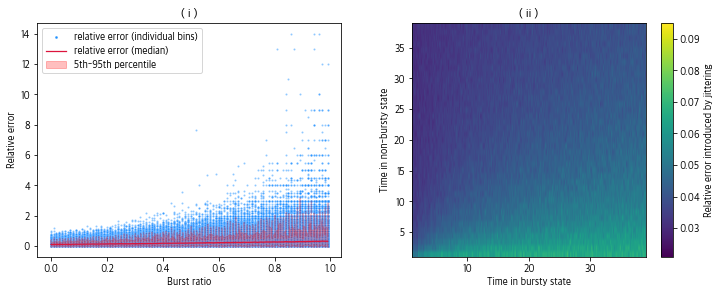

In [66]:
# as subplots

fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(12,4.3))
axs = axs.ravel()

# subplot i
axs[0].set_title('( i )')

# scatter plot of normalised errors for each value of k, removing any inf values where norm error is a list of errors for each value of k
sns.scatterplot(x=np.repeat(BR_s, len(norm_errors_BR[0])), y=norm_errors_BR.flatten(), s=4, alpha=0.5, label='relative error (individual bins)', color='dodgerblue', ax=axs[0])

# line plot of mean normalised error for each value of k
sns.lineplot(x=BR_s, y=np.nanmedian(norm_errors_BR, axis=1), c='crimson', label='relative error (median)', linewidth=1.25, ax=axs[0])

# ci for each value of k using 25th and 75th percentiles
axs[0].fill_between(BR_s, np.nanpercentile(norm_errors_BR, 5, axis=1), np.nanpercentile(norm_errors_BR, 95, axis=1), alpha=0.25, color='r', label = '5th-95th percentile')

# make scatterpoint in the legend larger

# add legend and move to bottom of chart below the x-axis
legend = axs[0].legend(loc='upper left',  shadow=False, ncol=1)
legend.legendHandles[0]._sizes = np.array([7.5])
# set alpha
legend.legendHandles[0].set_alpha(1) 

# axis labels
axs[0].set_xlabel('Burst ratio')
axs[0].set_ylabel('Relative error')

# # replace any inf values with 0
# norm_errors_A = np.array(norm_errors_A)
# norm_errors_A[norm_errors_A == np.inf] = 0

# # plot all errors for each value of k
# sns.scatterplot(x=np.repeat(A_s, len(norm_errors_A[0])), y=norm_errors_A.flatten(), s=4, alpha=0.5, label='normalised error (individual bins)',color='dodgerblue', ax=axs[0])
# # plt.title('Normalised error as a function of A')

# # # line plot of mean normalised error for each value of k
# sns.lineplot(x=A_s, y=np.nanmedian(norm_errors_A, axis=1), c='crimson',label='normalised error (median)', linewidth=1.25, ax=axs[0])

# # # ci for each value of k using 25th and 75th percentiles
# axs[0].fill_between(A_s, np.percentile(norm_errors_A, 5, axis=1), np.percentile(norm_errors_A, 95, axis=1), alpha=0.2, color='r', label = '5th-95th percentile')
# # axis labels
# axs[0].set_xlabel(r'Amplitude of periodic non-stationary effect, $A$')
# axs[0].set_ylabel('Normalised error')
# axs[0].legend(loc='upper center', bbox_to_anchor=(1.1, -.2), shadow=False, ncol=3)

# # subplot 2
axs[1].set_title('( ii )')
cchart = axs[1].imshow(zs2, vmin=norm_errors_BR_inactive.min()*1.15, vmax=norm_errors_BR_inactive.max()*0.95, origin='lower',
           extent=[bursty_states_.min(), bursty_states_.max(), non_bursty_states_.min(), non_bursty_states_.max()])
cbar = plt.colorbar(cchart, label='Relative error introduced by jittering')
axs[1].set_xlabel('Time in bursty state')
axs[1].set_ylabel('Time in non-bursty state')

# axs[1].set_ylabel('Normalised error')
plt.savefig('combined_jitter_br_error.pdf',  bbox_inches='tight')

# Old code

In [24]:

def flatten(xs):
    # function to flatten a list of lists or other iterables
    for x in xs:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            yield from flatten(x)
        else:
            yield x


# calculating parts of cross-correlogram
def expected_target_events_hj_delta(si, hj, delta, lambda_T):
    l= si + hj
    return integrate.quad(lambda_T, l, l+delta)[0] # integral from si+hj to si+hj+delta of lambda_T

def expected_bin_height(hj, lambda_S, lambda_T, delta, w, T):

    term = lambda x : lambda_S(x) * expected_target_events_hj_delta(x, hj, delta, lambda_T)
    return integrate.quad(term, w, T-w)[0] # integral from si+hj to si+hj+delta of lambda_S * E[events from T]

def sd_bin_height(hj, lambda_S, lambda_T, delta, w, T):
    term = lambda x : lambda_S(x) * expected_target_events_hj_delta(x, hj, delta, lambda_T)
    return integrate.quad(term, w, T-w)[0] # integral from si+hj to si+hj+delta of lambda_S * E[events from T]

# get absolute distance
def get_dist(l,x,u):
    if x<l:
        return l-x
    if x>u:
        return x-u
    else:
        return 0
    

# get the average rate for each interval and return as a np array
def get_rates(t, interval_size, t_min, t_max):
    intervals = np.arange(t_min, t_max, interval_size)
    rates = []
    for i in range(len(intervals)-1):
        rates.append(len(t[(t>=intervals[i]) & (t<intervals[i+1])]) / interval_size)
    return intervals[:-1], np.array(rates)

def jitter_times(t, interval_size, t_min, t_max):
    intervals = np.arange(t_min, t_max, interval_size)
    jittered_times = []
    for i in range(len(intervals)-1):
        jittered_times.append(intervals[i] + np.random.rand(len(t[(t>=intervals[i]) & (t<intervals[i+1])]))*interval_size)

    jittered_times.append(intervals[-1] + np.random.rand(len(t[(t>=intervals[-1])]))*interval_size)

    return np.array(list(flatten(jittered_times)))
    


def run_single_test(t1, t2, df, win, delta, T, tag_A = "A", tag_B = "B", factor_red = 10):

    fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(12,3.3))

    res = {}

    if type(t1) == list:
        t1 = np.array(t1)
    if type(t2)==list:
        t2 = np.array(t2)


    t1 = t1[t1>=win]
    t1 = t1[t1<=T-win]

    bins= np.arange(-win,win+delta,delta)
    to_zero = np.where((bins == -delta))[0][0], np.where(bins==0)[0][0]


    deltas = []

    for t in tqdm(np.array_split(t1, factor_red)): # auspol occurs 3.6 times more than the second most frequent - this is a safe value
        deltas.append(possible_time_del(t, t2, win, T))
    
    deltas = np.array(list(flatten(deltas)))

    ylim=None
    return_H = True
    lab = True

    title = None


    H, bins = np.histogram(deltas, bins= np.arange(-win,win+delta,delta))

    Hr = H.copy()

    for ind in to_zero:
        H[ind] = 0
    
    axs[0].bar(bins[:-1], H, width=np.diff(bins), align='center', label='observed')
    axs[2].bar(bins[:-1], H, width=np.diff(bins), align='center')

    # fit poisson ih
    lambda_1 = len(t1) / (T-2*win)
    lambda_2 = len(t2) / (T-2*win)

    # significance lines

    bins = np.arange(-win,win+delta,delta)
    b_heights = [expected_bin_height(x, lambda x : lambda_1,  lambda x : lambda_2, delta, win, T) for x in left_bin_edges(win, delta)]
    res['no_tod_lambdas'] = list(b_heights)
    axs[0].bar(bins[:-1], b_heights, width=np.diff(bins), align='center', label = 'theoretical', color='red', alpha=0.5)
    b_heights = np.array(b_heights)
    u = b_heights+3*np.sqrt(b_heights)
    l = b_heights-3*np.sqrt(b_heights)
    sns.lineplot(x=bins[:-1],y=b_heights+3*np.sqrt(b_heights), ax=axs[0],linestyle='--',color='red')
    sns.lineplot(x=bins[:-1], y=b_heights-3*np.sqrt(b_heights), ax=axs[0],linestyle='--',color='red', label = r'$\sigma$')

    axs[0].set_title(f'Cross-correlogram')#\nSignificance value: {np.sum([get_dist(lt,x,ut) for lt,x,ut in zip(l,H,u)]) / np.sum(H)}')

    # set y limits
    axs[0].set_ylim([np.max([0.95*np.min(b_heights-3*np.sqrt(b_heights)),0,0.95*np.min(H)]),1.05*np.max([np.max(H),np.max(b_heights+3*np.sqrt(b_heights))])])
    axs[0].set_xlabel('Inter-event times')
    
    ticks = np.arange(-win,win+delta, 60*30) # Now we know have many ticks you need
    labels = ["%.0f" % (x/(60)) for x in ticks] # Generate tick labels
    # xticks = ticks # and the actual positions of the ticks
    axs[0].set_xticks(ticks, labels=labels)
    axs[0].set_ylabel('Occurances')
    # ########################################

    # # Plot 2
    sns.histplot(data = df, x = 'hour', bins=24, hue='tag', alpha=0.2, ax=axs[1], palette=['red','#1f77b4'])
    # source
    x=np.arange(0,24,1)
    y1=df[df.tag==tag_A].groupby('hour').count()['tag'].reindex(index=x, fill_value=0).values
    y_min = np.min(y1)

    def func(x,a,c):
        return a*(np.sin(x/(24/(2*np.pi))+(18/(np.pi)))+c) # period of one day


    def func_with_pen(x,a,c):
        return func(x, a, c)

    fit_p1,_ = curve_fit(func_with_pen, x, y1)
    sns.lineplot(x=x, y=func_with_pen(x, *fit_p1), color='red', ax=axs[1], linewidth=3)
    mse1 = np.mean((y1-func_with_pen(x, *fit_p1))**2)
    # target
    y2=df[df.tag==tag_B].groupby('hour').count()['tag'].reindex(index=x, fill_value=0).values
    y_min2 = np.min(y1)

    def func(x,a,c):
        return a*(np.sin(x/(24/(2*np.pi))+(14/(np.pi)))+c) # period of one day


    def func_with_pen(x,a,c):
        return func(x, a, c)
    fit_p2,_ = curve_fit(func_with_pen, x, y2)
    sns.lineplot(x=x, y=func_with_pen(x, *fit_p2), color='#1f77b4', ax=axs[1], linewidth=3)
    mse2 = np.mean((y2-func_with_pen(x, *fit_p2))**2)
    axs[1].set_title(f"TOD model fit")#\nMSE for #{tag_A} : {round(mse1,3)},\t\t\t\t\t MSE for #{tag_B} : {round(mse2,3)}")

    # ##################################################
    # # plot 3 - cross-correlogram, no TOD effect

    def lambda_s(x):
        # divide by number of days in dataset
        return fit_p2[0]*(np.sin(x/(24/(2*np.pi))+(18/(np.pi)))+fit_p2[1]) /(T//24)

    def lambda_t(x):
        # divide by number of days in dataset
        return fit_p2[0]*(np.sin(x/(24/(2*np.pi))+(14/(np.pi)))+fit_p2[1])  /(T//24)

    # H, _ = plot_cross_correlogram(np.array(t1),np.array(t2),win,T,delta,ylim=None, ax=axs[2], return_H = True, lab=True)
    # res['tod_h'] = list(H)
    # significance lines

    bins = np.arange(-win,win+delta,delta)
    b_heights_tod = [expected_bin_height(x, lambda_s,  lambda_t, delta, win, 14*T)/14 for x in left_bin_edges(win, delta)]
    res['tod_lambdas'] = list(b_heights_tod)

    axs[2].bar(bins[:-1], b_heights_tod, width=np.diff(bins), align='center', label = 'theoretical', color='red', alpha=0.5)
    b_heights_tod = np.array(b_heights_tod)
    u2 = b_heights_tod+3*np.sqrt(b_heights_tod)
    l2 = b_heights_tod-3*np.sqrt(b_heights_tod)
    sns.lineplot(x=bins[:-1],y=b_heights_tod+3*np.sqrt(b_heights_tod), ax=axs[2],linestyle='--',color='red')
    sns.lineplot(x=bins[:-1], y=b_heights_tod-3*np.sqrt(b_heights_tod), ax=axs[2],linestyle='--',color='red')

    axs[2].set_title(f'Cross-correlogram including TOD effect')#\nSignificance value: {np.sum([get_dist(lt,x,ut) for lt,x,ut in zip(l,H,u)]) / np.sum(H)}')

    # set y limits
    axs[2].set_ylim([np.max([0.95*np.min(b_heights_tod-3*np.sqrt(b_heights_tod)),0,0.95*np.min(H)]),1.05*np.max([np.max(H),np.max(b_heights_tod+3*np.sqrt(b_heights_tod))])])
    axs[2].set_xlabel('Inter-event times')
    axs[2].set_ylabel('Occurances')

    # set all the font sizes to large
    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.tick_params(axis='both', which='minor', labelsize=10)
        ax.set_xlabel(ax.get_xlabel(), fontsize=15)
        ax.set_ylabel(ax.get_ylabel(), fontsize=15)
        ax.set_title(ax.get_title(), fontsize=15)

    axs[0].legend(loc='upper center', bbox_to_anchor=(1.7, -0.17), shadow=True, ncol=3)

    axs[2].legend().set_visible(False)

    plt.savefig(f'{tag_A}_{tag_B}2.pdf', bbox_inches='tight')
    # save res
    # res to dataframe
    # save res
    # pd.DataFrame(res).to_csv(f'{tag_A}_{tag_B}_bin_heights.csv', index=False)
    return H, bins, u, l, u2, l2

In [14]:
# T = 7*24*60*60 # 1 months
# win = 3*60*60
n_bins_per_unit = 4 # hist bin width is 15 seconds
delta = 1/n_bins_per_unit

tag_A ="A"
tag_B = "B"

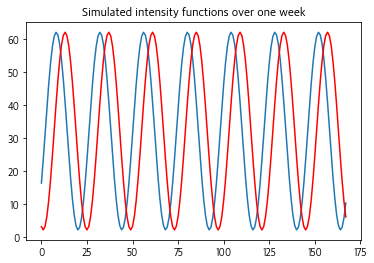

In [15]:
# T measured in seconds

T_max = 30*24 # over 30 days
T = T_max
l_av = 1.01 # average rate

win = 3 # 3 hours
delta = 0.25 # 15 minutes
def lambda_s(x):
    return 30*(np.sin((x)/(24/(2*np.pi))+(18/(np.pi)))+1.07) # period of one day

def lambda_t(x):
    return 30*(np.sin((x)/(24/(2*np.pi))+(14/(np.pi)))+1.07) # period of one day out by a bit


x_ = np.arange(0,7*24)#T_max,100) # one week
plt.title('Simulated intensity functions over one week')
sns.lineplot(x=x_,y=lambda_s(x_),color='#1f77b4')
sns.lineplot(x=x_,y=lambda_t(x_),color='r')

d = []

t1_ = gen_poisson_ih(lambda_s, T_max);
t2_ = gen_poisson_ih(lambda_t, T_max);
plt.savefig('testintensity.pdf', bbox_inches='tight')

In [16]:
len(t1_), len(t2_)

(23142, 23315)

In [17]:
# remove 0.5 of the data
t1 = t1_#[np.random.rand(len(t1_))>0.9]
t2 = t2_#[np.random.rand(len(t2_))>0.9]

# now add some events to t2 which are from t1 with a small delay
# to_add = np.random.choice(t1, size = len(t1)//10) + 60*60*0.5*np.random.rand(len(t1)//10) + 60*60

# t2 = np.concatenate([t2,to_add])

# sort t2
t2 = np.sort(t2)

In [18]:
df = pd.DataFrame({'tag':len(t1)*['A']+len(t2)*['B'], 'time':list(t1)+list(t2)})

# process times
df['hours'] = np.floor(df.time)
df['hour'] = np.mod(df.hours,24)

<Axes: xlabel='hour', ylabel='Count'>

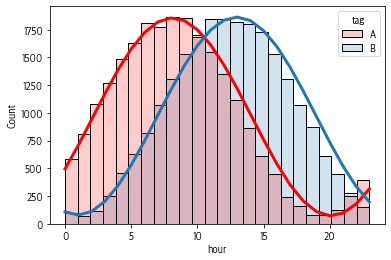

In [19]:
sns.histplot(data = df, x = 'hour', bins=24, hue='tag', alpha=0.2,  palette=['red','#1f77b4'])
    
x=np.arange(0,24,1)
y1=df[df.tag==tag_A].groupby('hour').count()['tag'].reindex(index=x, fill_value=0).values
y_min = np.min(y1)
# fit TOD model
# def func(x,a,b):
#     return -a * (x-b)**2 * (x) * (x-24) + y_min

# def func_with_pen(x,a,b,c,d):
#     return func(x, a, b,c,d) + 1e8*(func(0, a,b,c,d)-func(24, a, b,c,d))

def func(x,a,c):
    return a*(np.sin(x/(24/(2*np.pi))+(18/(np.pi)))+c) # period of one day


def func_with_pen(x,a,c):
    return func(x, a, c)

fit_p1,_ = curve_fit(func_with_pen, x, y1)
sns.lineplot(x=x, y=func_with_pen(x, *fit_p1), color='red',  linewidth=3)
# mse1 = np.mean((y1-func_with_pen(x, *fit_p1))**2)
# target
y2=df[df.tag==tag_B].groupby('hour').count()['tag'].reindex(index=x, fill_value=0).values
y_min2 = np.min(y1)


def func(x,a,c):
    return a*(np.sin(x/(24/(2*np.pi))+(14/(np.pi)))+c) # period of one day


def func_with_pen(x,a,c):
    return func(x, a, c)

# def func(x,a,b,c,d):
#     return -a * (x-b)**2 * (x-d) * (x-c) + y_min2

fit_p2,_ = curve_fit(func_with_pen, x, y2)
sns.lineplot(x=x, y=func_with_pen(x, *fit_p2), color='#1f77b4', linewidth=3)

In [20]:
T_max

720

  0%|          | 0/10 [00:00<?, ?it/s]

/var/folders/wp/758jq81s3hs0jlp8_31261sc0000gn/T/ipykernel_2176/1701365353.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(term, w, T-w)[0] # integral from si+hj to si+hj+delta of lambda_S * E[events from T]


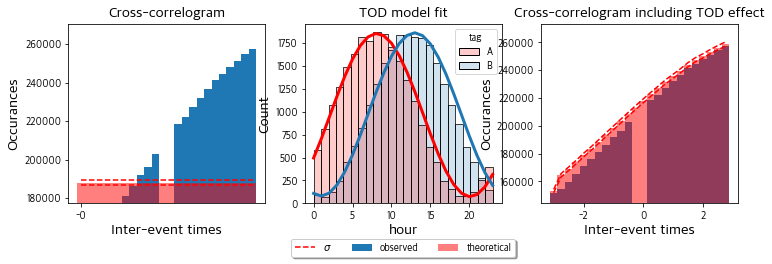

In [25]:
H, bins, u, l, u2, l2 = run_single_test(t1, t2, df, win, delta, T_max)

## equivalent plot using smoothly varying intensity functions

In [7]:

import numpy as np, pandas as pd
from scipy.stats import chisquare

from itertools import combinations
# requires pip install "pandas<2.0.0"

import matplotlib.pyplot as plt, seaborn as sns
import matplotlib as mpl

import math, string, re, pickle, json, time, os, sys, datetime, itertools
import igraph as ig
from tqdm.notebook import tqdm

from assess_dataset_functions import count_tags

from collections.abc import Iterable

# need a function to flatten irregular list of lists
def flatten(xs):
    for x in xs:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            yield from flatten(x)
        else:
            yield x

from cross_correlogram import *
from simulating_hawkes import *

# circadian / time of day effect

from scipy.optimize import curve_fit

import scipy.integrate as integrate
def expected_target_events_hj_delta(si, hj, delta, lambda_T):
    l= si + hj
    return integrate.quad(lambda_T, l, l+delta)[0] # integral from si+hj to si+hj+delta of lambda_T
def expected_bin_height(hj, lambda_S, lambda_T, delta, w, T):
    term = lambda x : lambda_S(x) * expected_target_events_hj_delta(x, hj, delta, lambda_T)
    return integrate.quad(term, w, T-w)[0] # integral from si+hj to si+hj+delta of lambda_S * E[events from T]
def sd_bin_height(hj, lambda_S, lambda_T, delta, w, T):
    term = lambda x : lambda_S(x) * expected_target_events_hj_delta(x, hj, delta, lambda_T)
    return integrate.quad(term, w, T-w)[0] # integral from si+hj to si+hj+delta of lambda_S * E[events from T]

# test on simulated data
def get_dist(l,x,u):
    if x<l:
        return l-x
    if x>u:
        return x-u
    else:
        return 0


# get the average rate for each interval and return as a np array
def get_rates(t, interval_size, t_min, t_max):
    intervals = np.arange(t_min, t_max, interval_size)
    rates = []
    for i in range(len(intervals)-1):
        rates.append(len(t[(t>=intervals[i]) & (t<intervals[i+1])]) / interval_size)
    return intervals[:-1], np.array(rates)


def way_too_large_plus_smooth(t1,t2, win, delta, T, interval_size, factor_red = 8):
    if type(t1) == list:
        t1 = np.array(t1)
    if type(t2)==list:
        t2 = np.array(t2)


    t1 = t1[t1>=win]
    t1 = t1[t1<=T-win]

    bins= np.arange(-win,win+delta,delta)
    to_zero = np.where((bins == -delta))[0][0], np.where(bins==0)[0][0]


    deltas = []

    for t in np.array_split(t1, factor_red): # auspol occurs 3.6 times more than the second most frequent - this is a safe value
        deltas.append(possible_time_del(t, t2, win, T))
    
    deltas = np.array(list(flatten(deltas)))

    ylim=None
    return_H = True
    lab = True

    title = None

    res = {}
    fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(12,4.3))

    H, bins = np.histogram(deltas, bins= np.arange(-win,win+delta,delta))

    Hr = H.copy()

    for ind in to_zero:
        H[ind] = 0
    
    if not lab:
        axs[0].bar(bins[:-1], H, width=np.diff(bins), align='center')
    else:
        axs[0].bar(bins[:-1], H, width=np.diff(bins), align='center', label='observed')

    # if not title:
    #     axs[0].set_title(rf'Cross-correlogram, $\delta$')
    # else:
    #     axs[0].set_title(title)
    if ylim:
        axs[0].set_ylim(ylim[0],ylim[1])
    else:
        axs[0].set_ylim(0.8*np.min(H),1.1*np.max(H))

    res['no_jitter_h'] = list(H)
    # fit poisson homogeneous
    lambda_1 = len(t1) / (np.max(t1) - np.min(t1))
    lambda_2 = len(t2) / (np.max(t2) - np.min(t2))

    # significance lines


    bins = np.arange(-win,win+delta,delta)
    b_heights = [expected_bin_height(x, lambda x : lambda_1,  lambda x : lambda_2, delta, win, T) for x in left_bin_edges(win, delta)]
    res['no_tod_lambdas'] = list(b_heights)
    axs[0].bar(bins[:-1], b_heights, width=np.diff(bins), align='center', label = 'theoretical', color='red', alpha=0.5)
    b_heights = np.array(b_heights)
    u = b_heights+3*np.sqrt(b_heights)
    l = b_heights-3*np.sqrt(b_heights)
    sns.lineplot(x=bins[:-1],y=b_heights+3*np.sqrt(b_heights),linestyle='--',color='red', ax=axs[0], label = r'$\sigma$')
    sns.lineplot(x=bins[:-1], y=b_heights-3*np.sqrt(b_heights),linestyle='--',color='red', ax=axs[0])

    sig1v = np.array([get_dist(lt,x,ut) for lt,x,ut in zip(l,H,u)])
    for ind in to_zero:
        sig1v[ind] = 0
    sig1 = np.sum(sig1v) / np.sum(H)
    # p value for poisson null model

    obs = np.array(H)
    obs = np.delete(obs,to_zero)
    exp = np.delete(b_heights,to_zero)
    sig2 = chisquare(obs*np.sum(exp)/np.sum(obs),exp)
    df = len(H)-1 - len(to_zero)

    # set y limits
    y_limits_og = [np.min([0.95*np.min(b_heights-3*np.sqrt(b_heights)),0,0.95*np.min(H)]),1.05*np.max([np.max(H),np.max(b_heights+3*np.sqrt(b_heights))])]

    
    # axs[0].set_xlabel('Offset (hours)')
    axs[0].set_ylabel('Occurances')

    axs[0].set_xlabel('Offset (Minutes)')
    ticks = np.arange(-win,win+delta, 60*30) # Now we know have many ticks you need
    labels = ["%.0f" % (x/(60)) for x in ticks] # Generate tick labels
    # xticks = ticks # and the actual positions of the ticks
    axs[0].set_xticks(ticks, labels=labels, fontsize='small')

    axs[0].legend(loc='upper center', bbox_to_anchor=(1.1, -0.17), shadow=True, ncol=2)

    axs[0].set_title(f'Constant null model', fontsize='medium',ha='left', loc='left')

    ##################################################
    # second jittered plot

    s_times = np.array(t1)
    t_times = np.array(t2)
    
    def lambda_func(x, i__, r__):
        if x < win:
            return 0
        if x > (T-win):
            return 0
        else: 
            return r__[i__>=x][0]
            

    i_s, r_s = get_rates(s_times, interval_size, win,np.max([np.max(s_times),T-win])+2*interval_size)
    i_t, r_t = get_rates(t_times, interval_size, win, np.max([np.max(t_times),T-win])+2*interval_size)

    lambda_s = lambda x : lambda_func(x, i_s, r_s)
    lambda_t = lambda x : lambda_func(x, i_t, r_t)

    # plot observed
    if not lab:
        axs[1].bar(bins[:-1], H, width=np.diff(bins), align='center')
    else:
        axs[1].bar(bins[:-1], H, width=np.diff(bins), align='center', label='observed')

    # if not title:
    #     axs[1].set_title(rf'Cross-correlogram, $\delta$')
    # else:
    #     axs[1].set_title(title)
    if ylim:
        axs[1].set_ylim(ylim[0],ylim[1])
    else:
        axs[1].set_ylim(0.8*np.min(H),1.1*np.max(H))



    res['jitter_h'] = list(H)


    bins = np.arange(-win,win+delta,delta)
    b_heights_smooth = [expected_bin_height(x, lambda_s,  lambda_t, delta, win, T) for x in left_bin_edges(win, delta)]
    res['tod_lambdas'] = list(b_heights_smooth)
    axs[1].bar(bins[:-1], b_heights_smooth, width=np.diff(bins), align='center', label = 'theoretical', color='red', alpha=0.5)
    # b_heights_smooth = b_heights_smooth[1:] + [b_heights_smooth[-1]]
    b_heights_smooth = np.array(b_heights_smooth)
    u = b_heights_smooth+3*np.sqrt(b_heights_smooth)
    l = b_heights_smooth-3*np.sqrt(b_heights_smooth)
    sns.lineplot(x=bins[:-1],y=b_heights_smooth+3*np.sqrt(b_heights_smooth), ax=axs[1],linestyle='--',color='red')
    sns.lineplot(x=bins[:-1], y=b_heights_smooth-3*np.sqrt(b_heights_smooth), ax=axs[1],linestyle='--',color='red')

    sig3v = np.array([get_dist(lt,x,ut) for lt,x,ut in zip(l,H,u)]) / np.sum(H)
    for ind in to_zero:
        sig3v[ind]=0
        
    sig3 = np.sum(sig3v**2) / np.sum(H)
    midpoints = (bins[:-1] + delta/2)
    sig4 = midpoints[np.argmax(sig3v)]
    sig5 = np.average(midpoints, weights = sig3v)
    

    axs[1].set_title(f'Inhomogeneous null model', fontsize='medium', ha='left', loc = 'left')
    # set y limits
    axs[1].set_xlabel('Offset (Minutes)')
    ticks = np.arange(-win,win+delta, 60*30) # Now we know have many ticks you need
    labels = ["%.0f" % (x/(60)) for x in ticks] # Generate tick labels
    # xticks = ticks # and the actual positions of the ticks
    axs[1].set_xticks(ticks, labels=labels, fontsize='small')

    axs[1].set_ylabel('Occurances')

    # turn off legend on ax1
    axs[1].legend().set_visible(False)


    #### y limits
    y_limits_new = [np.min([0.95*np.min(b_heights_smooth-3*np.sqrt(b_heights_smooth)),0,0.95*np.min(H)]),1.05*np.max([np.max(H),np.max(b_heights_smooth+3*np.sqrt(b_heights_smooth))])]

    y_limits_ = [np.min([y_limits_og[0], y_limits_new[0]]), np.max([y_limits_og[1], y_limits_new[1]])]
    
    axs[0].set_ylim(y_limits_)

    axs[1].set_ylim(y_limits_)
    ##################################################
    # plt.suptitle(fr'#{tag_A} $\rightarrow$ #{tag_B}', y=1.08, x=0.48)

    axs[0].legend(loc='upper center', bbox_to_anchor=(1, -0.17), shadow=True, ncol=3)
    
    # save figures
    plt.savefig(f'A_B_smooth1.pdf', bbox_inches='tight')

    return True #float(np.sum(H)),sig1, sig2[0],sig2[1], sig3, sig4, sig5, df, list([int(x) for x in Hr])

/var/folders/wp/758jq81s3hs0jlp8_31261sc0000gn/T/ipykernel_4271/1721856752.py:39: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(term, w, T-w)[0] # integral from si+hj to si+hj+delta of lambda_S * E[events from T]


True

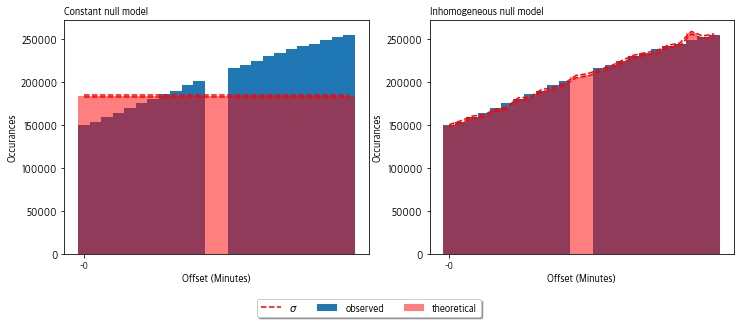

In [12]:
way_too_large_plus_smooth(t1,t2, win, delta, T, interval_size=1, factor_red = 8)

## jitter also

<Axes: title={'center': 'Simulated intensity functions over one week'}>

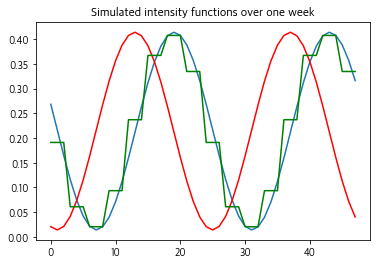

In [8]:


A = 1/5
b = 24
d = -24*14/np.pi
c2 = 1.07 * 1/5

def lambda_t(x):
    return 1/5*(np.sin((x)/(24/(2*np.pi))+(14/(np.pi)))+1.07) # period of one day out by a bit

lambda_t_dash = lambda t: c2 + A * np.sin( (t-d) * (2 * math.pi) / b)


delta = 3
lambda_t_jittered = lambda t: c2 + (A*b / (2 * math.pi*delta)) * (np.cos((2*math.pi)/b* (d - (t // delta )* delta)) - np.cos((2*math.pi)/b* (d - ((t // delta) +1 )* delta)))


x_ = np.arange(0,48)#T_max,100) # one week
plt.title('Simulated intensity functions over one week')
sns.lineplot(x=x_,y=lambda_t_dash(x_),color='#1f77b4')
sns.lineplot(x=x_,y=lambda_t(x_),color='r')
sns.lineplot(x=x_,y=lambda_t_jittered(x_),color='g')


In [9]:

def jitter_test(t1, t2, tj, win, delta, T, tag_A = "A", tag_B = "B", factor_red = 10):

    fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(8,3.3))

    res = {}

    if type(t1) == list:
        t1 = np.array(t1)
    if type(t2)==list:
        t2 = np.array(t2)
    if type(tj)==list:
        tj = np.array(tj)


    t1 = t1[t1>=win]
    t1 = t1[t1<=T-win]

    bins= np.arange(-win,win+delta,delta)
    to_zero = np.where((bins == -delta))[0][0], np.where(bins==0)[0][0]


    deltas = []
    deltas_jitter = []
    for t in tqdm(np.array_split(t1, factor_red)): # auspol occurs 3.6 times more than the second most frequent - this is a safe value
        deltas.append(possible_time_del(t, t2, win, T))
        deltas_jitter.append(possible_time_del(t, tj, win, T))
    
    deltas = np.array(list(flatten(deltas)))
    deltas_jitter = np.array(list(flatten(deltas_jitter)))

    ylim=None
    return_H = True
    lab = True

    title = None


    H, bins = np.histogram(deltas, bins= np.arange(-win,win+delta,delta))

    Hr = H.copy()

    for ind in to_zero:
        H[ind] = 0
    
    axs[0].bar(bins[:-1], H, width=np.diff(bins), align='center', label='observed')

    # fit poisson ih
    lambda_1 = len(t1) / (T-2*win)
    lambda_2 = len(t2) / (T-2*win)

    # significance lines

    bins = np.arange(-win,win+delta,delta)
    b_heights = [expected_bin_height(x, lambda x : lambda_1,  lambda x : lambda_2, delta, win, T) for x in left_bin_edges(win, delta)]
    res['no_tod_lambdas'] = list(b_heights)
    axs[0].bar(bins[:-1], b_heights, width=np.diff(bins), align='center', label = 'theoretical', color='red', alpha=0.5)
    b_heights = np.array(b_heights)
    u = b_heights+3*np.sqrt(b_heights)
    l = b_heights-3*np.sqrt(b_heights)
    sns.lineplot(x=bins[:-1],y=b_heights+3*np.sqrt(b_heights), ax=axs[0],linestyle='--',color='red')
    sns.lineplot(x=bins[:-1], y=b_heights-3*np.sqrt(b_heights), ax=axs[0],linestyle='--',color='red', label = r'$\sigma$')

    axs[0].set_title(f'Cross-correlogram')#\nSignificance value: {np.sum([get_dist(lt,x,ut) for lt,x,ut in zip(l,H,u)]) / np.sum(H)}')

    # set y limits
    axs[0].set_ylim([np.max([0.95*np.min(b_heights-3*np.sqrt(b_heights)),0,0.95*np.min(H)]),1.05*np.max([np.max(H),np.max(b_heights+3*np.sqrt(b_heights))])])
    axs[0].set_xlabel('Inter-event times')
    
    ticks = np.arange(-win,win+delta, 60*30) # Now we know have many ticks you need
    labels = ["%.0f" % (x/(60)) for x in ticks] # Generate tick labels
    # xticks = ticks # and the actual positions of the ticks
    axs[0].set_xticks(ticks, labels=labels)
    axs[0].set_ylabel('Occurances')
    # ########################################



    H, bins = np.histogram(deltas_jitter, bins= np.arange(-win,win+delta,delta))

    for ind in to_zero:
        H[ind] = 0
    
    axs[1].bar(bins[:-1], H, width=np.diff(bins), align='center', label='observed')

    # significance lines

    axs[1].bar(bins[:-1], b_heights, width=np.diff(bins), align='center', label = 'theoretical', color='red', alpha=0.5)
    b_heights = np.array(b_heights)
    u = b_heights+3*np.sqrt(b_heights)
    l = b_heights-3*np.sqrt(b_heights)
    sns.lineplot(x=bins[:-1],y=b_heights+3*np.sqrt(b_heights), ax=axs[1],linestyle='--',color='red')
    sns.lineplot(x=bins[:-1], y=b_heights-3*np.sqrt(b_heights), ax=axs[1],linestyle='--',color='red', label = r'$\sigma$')

    axs[1].set_title(f'Jittered')#\nSignificance value: {np.sum([get_dist(lt,x,ut) for lt,x,ut in zip(l,H,u)]) / np.sum(H)}')

    # set y limits
    axs[1].set_ylim([np.max([0.95*np.min(b_heights-3*np.sqrt(b_heights)),0,0.95*np.min(H)]),1.05*np.max([np.max(H),np.max(b_heights+3*np.sqrt(b_heights))])])
    axs[1].set_xlabel('Inter-event times')
    
    ticks = np.arange(-win,win+delta, 60*30) # Now we know have many ticks you need
    labels = ["%.0f" % (x/(60)) for x in ticks] # Generate tick labels
    # xticks = ticks # and the actual positions of the ticks
    axs[1].set_xticks(ticks, labels=labels)
    axs[1].set_ylabel('Occurances')
    axs[1].legend(loc='upper center', bbox_to_anchor=(1.7, -0.17), shadow=True, ncol=3)

    axs[1].legend().set_visible(False)

    axs[0].legend(loc='upper center', bbox_to_anchor=(1.1, -0.17), shadow=True, ncol=3)
    plt.savefig(f'{tag_A}_{tag_B}_jitter.pdf', bbox_inches='tight')
    # save res
    # res to dataframe
    # save res
    # pd.DataFrame(res).to_csv(f'{tag_A}_{tag_B}_bin_heights.csv', index=False)
    return True

In [10]:
# T = 7*24*60*60 # 1 months
# win = 3*60*60
n_bins_per_unit = 4 # hist bin width is 15 seconds
delta = 1/n_bins_per_unit

tag_A ="A"
tag_B = "B"

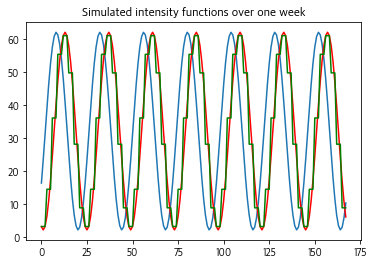

In [11]:
# T measured in seconds

T_max = 30*24 # over 1  month
T = T_max

A = 30
b = 24
d = -24*14/(2*np.pi**2)
c2 = 1.07 * A
interval_jitter = 3

win = 3 # 3 hours
delta = 0.25 # 15 minutes
def lambda_s(x):
    return A*(np.sin((x)/(24/(2*np.pi))+(18/(np.pi)))+1.07) # period of one day

def lambda_t(x):
    return A*(np.sin((x)/(24/(2*np.pi))+(14/(np.pi)))+1.07) # period of one day out by a bit



# lambda_t_jittered = lambda t: c2 + (A*b / (2 * math.pi*interval_jitter)) * (np.cos((2*math.pi)/b* (d - (t // interval_jitter )* interval_jitter)) - np.cos((2*math.pi)/b* (d - ((t // interval_jitter) +1 )* interval_jitter)))

def lambda_t_jittered(x):
    return c2 + (A*b / (2 * np.pi*interval_jitter)) * (np.cos((2*np.pi)/b  * (d - (x // interval_jitter )* interval_jitter))- np.cos((2*np.pi)/b* (d - ((x // interval_jitter) +1 )* interval_jitter)))

# w=3

x_ = np.arange(0,7*24)#T_max,100) # one week
plt.title('Simulated intensity functions over one week')
sns.lineplot(x=x_,y=lambda_s(x_),color='#1f77b4')
sns.lineplot(x=x_,y=lambda_t(x_),color='r')
sns.lineplot(x=x_,y=lambda_t_jittered(x_),color='g')

# d = []

t1_ = gen_poisson_ih(lambda_s, T_max);
t2_ = gen_poisson_ih(lambda_t, T_max);
tj_ = gen_poisson_ih(lambda_t_jittered, T_max);

In [12]:
len(t1_), len(t2_), len(tj_)

(23245, 23051, 23220)

In [18]:
# remove 0.5 of the data
t1 = t1_#[np.random.rand(len(t1_))>0.9]
t2 = t2_#[np.random.rand(len(t2_))>0.9]
tj = tj_#[np.random.rand(len(tj_))>0.9]

# now add some events to t2 which are from t1 with a small delay
# to_add = np.random.choice(t1, size = len(t1)//10) + 60*60*0.5*np.random.rand(len(t1)//10) + 60*60

# t2 = np.concatenate([t2,to_add])


  0%|          | 0/10 [00:00<?, ?it/s]

True

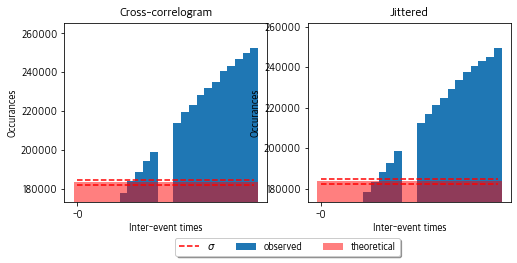

In [19]:
jitter_test(t1, t2, tj, win, delta, T_max)

In [20]:
# T = 7*24*60*60 # 1 months
# win = 3*60*60
n_bins_per_unit = 4 # hist bin width is 15 seconds
delta = 1/n_bins_per_unit

tag_A ="A"
tag_B = "B"

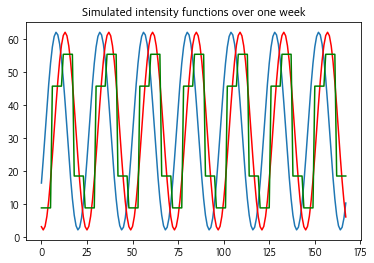

In [21]:
# T measured in seconds

T_max = 30*24 # over 1  month
T = T_max

A = 30
b = 24
d = -24*14/(2*np.pi**2)
c2 = 1.07 * A
interval_jitter = 6

win = 3 # 3 hours
delta = 0.25 # 15 minutes
def lambda_s(x):
    return A*(np.sin((x)/(24/(2*np.pi))+(18/(np.pi)))+1.07) # period of one day

def lambda_t(x):
    return A*(np.sin((x)/(24/(2*np.pi))+(14/(np.pi)))+1.07) # period of one day out by a bit



# lambda_t_jittered = lambda t: c2 + (A*b / (2 * math.pi*interval_jitter)) * (np.cos((2*math.pi)/b* (d - (t // interval_jitter )* interval_jitter)) - np.cos((2*math.pi)/b* (d - ((t // interval_jitter) +1 )* interval_jitter)))

def lambda_t_jittered(x):
    return c2 + (A*b / (2 * np.pi*interval_jitter)) * (np.cos((2*np.pi)/b  * (d - (x // interval_jitter )* interval_jitter))- np.cos((2*np.pi)/b* (d - ((x // interval_jitter) +1 )* interval_jitter)))

# w=3

x_ = np.arange(0,7*24)#T_max,100) # one week
plt.title('Simulated intensity functions over one week')
sns.lineplot(x=x_,y=lambda_s(x_),color='#1f77b4')
sns.lineplot(x=x_,y=lambda_t(x_),color='r')
sns.lineplot(x=x_,y=lambda_t_jittered(x_),color='g')

# d = []

t1_ = gen_poisson_ih(lambda_s, T_max);
t2_ = gen_poisson_ih(lambda_t, T_max);
tj_ = gen_poisson_ih(lambda_t_jittered, T_max);

In [22]:
len(t1_), len(t2_), len(tj_)

(23145, 23303, 23013)

In [23]:
# remove 0.5 of the data
t1 = t1_#[np.random.rand(len(t1_))>0.9]
t2 = t2_#[np.random.rand(len(t2_))>0.9]
tj = tj_#[np.random.rand(len(tj_))>0.9]

# now add some events to t2 which are from t1 with a small delay
# to_add = np.random.choice(t1, size = len(t1)//10) + 60*60*0.5*np.random.rand(len(t1)//10) + 60*60

# t2 = np.concatenate([t2,to_add])


  0%|          | 0/10 [00:00<?, ?it/s]

True

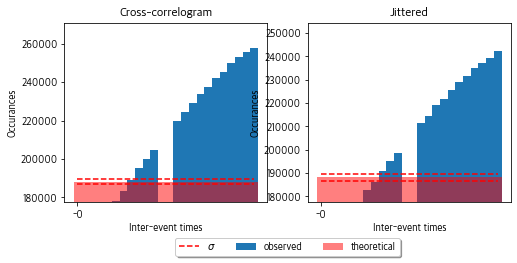

In [24]:
jitter_test(t1, t2, tj, win, delta, T_max)

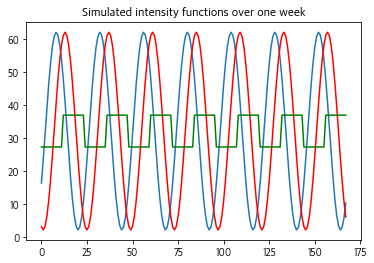

In [25]:
# T measured in seconds

T_max = 30*24 # over 1  month
T = T_max

A = 30
b = 24
d = -24*14/(2*np.pi**2)
c2 = 1.07 * A
interval_jitter = 12

win = 3 # 3 hours
delta = 0.25 # 15 minutes
def lambda_s(x):
    return A*(np.sin((x)/(24/(2*np.pi))+(18/(np.pi)))+1.07) # period of one day

def lambda_t(x):
    return A*(np.sin((x)/(24/(2*np.pi))+(14/(np.pi)))+1.07) # period of one day out by a bit



# lambda_t_jittered = lambda t: c2 + (A*b / (2 * math.pi*interval_jitter)) * (np.cos((2*math.pi)/b* (d - (t // interval_jitter )* interval_jitter)) - np.cos((2*math.pi)/b* (d - ((t // interval_jitter) +1 )* interval_jitter)))

def lambda_t_jittered(x):
    return c2 + (A*b / (2 * np.pi*interval_jitter)) * (np.cos((2*np.pi)/b  * (d - (x // interval_jitter )* interval_jitter))- np.cos((2*np.pi)/b* (d - ((x // interval_jitter) +1 )* interval_jitter)))

# w=3

x_ = np.arange(0,7*24)#T_max,100) # one week
plt.title('Simulated intensity functions over one week')
sns.lineplot(x=x_,y=lambda_s(x_),color='#1f77b4')
sns.lineplot(x=x_,y=lambda_t(x_),color='r')
sns.lineplot(x=x_,y=lambda_t_jittered(x_),color='g')

# d = []

t1_ = gen_poisson_ih(lambda_s, T_max);
t2_ = gen_poisson_ih(lambda_t, T_max);
tj_ = gen_poisson_ih(lambda_t_jittered, T_max);

In [26]:
len(t1_), len(t2_), len(tj_)

(23403, 23195, 23094)

In [27]:
# remove 0.5 of the data
t1 = t1_#[np.random.rand(len(t1_))>0.9]
t2 = t2_#[np.random.rand(len(t2_))>0.9]
tj = tj_#[np.random.rand(len(tj_))>0.9]

# now add some events to t2 which are from t1 with a small delay
# to_add = np.random.choice(t1, size = len(t1)//10) + 60*60*0.5*np.random.rand(len(t1)//10) + 60*60

# t2 = np.concatenate([t2,to_add])


  0%|          | 0/10 [00:00<?, ?it/s]

True

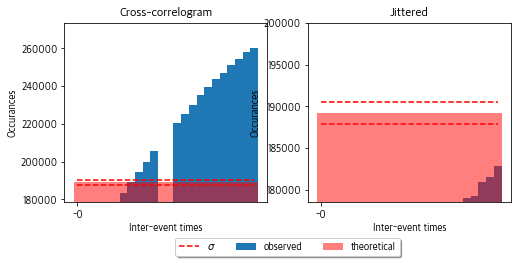

In [28]:
jitter_test(t1, t2, tj, win, delta, T_max)

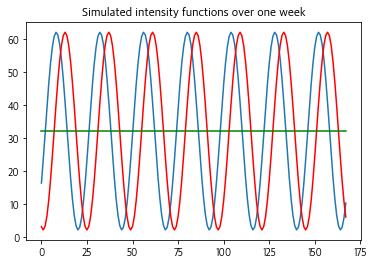

In [29]:
# T measured in seconds

T_max = 30*24 # over 1  month
T = T_max

A = 30
b = 24
d = -24*14/(2*np.pi**2)
c2 = 1.07 * A
interval_jitter = 24

win = 3 # 3 hours
delta = 0.25 # 15 minutes
def lambda_s(x):
    return A*(np.sin((x)/(24/(2*np.pi))+(18/(np.pi)))+1.07) # period of one day

def lambda_t(x):
    return A*(np.sin((x)/(24/(2*np.pi))+(14/(np.pi)))+1.07) # period of one day out by a bit



# lambda_t_jittered = lambda t: c2 + (A*b / (2 * math.pi*interval_jitter)) * (np.cos((2*math.pi)/b* (d - (t // interval_jitter )* interval_jitter)) - np.cos((2*math.pi)/b* (d - ((t // interval_jitter) +1 )* interval_jitter)))

def lambda_t_jittered(x):
    return c2 + (A*b / (2 * np.pi*interval_jitter)) * (np.cos((2*np.pi)/b  * (d - (x // interval_jitter )* interval_jitter))- np.cos((2*np.pi)/b* (d - ((x // interval_jitter) +1 )* interval_jitter)))

# w=3

x_ = np.arange(0,7*24)#T_max,100) # one week
plt.title('Simulated intensity functions over one week')
sns.lineplot(x=x_,y=lambda_s(x_),color='#1f77b4')
sns.lineplot(x=x_,y=lambda_t(x_),color='r')
sns.lineplot(x=x_,y=lambda_t_jittered(x_),color='g')

# d = []

t1_ = gen_poisson_ih(lambda_s, T_max);
t2_ = gen_poisson_ih(lambda_t, T_max);
tj_ = gen_poisson_ih(lambda_t_jittered, T_max);

In [30]:
len(t1_), len(t2_), len(tj_)

(22895, 23215, 23258)

In [31]:
# remove 0.5 of the data
t1 = t1_#[np.random.rand(len(t1_))>0.9]
t2 = t2_#[np.random.rand(len(t2_))>0.9]
tj = tj_#[np.random.rand(len(tj_))>0.9]

# now add some events to t2 which are from t1 with a small delay
# to_add = np.random.choice(t1, size = len(t1)//10) + 60*60*0.5*np.random.rand(len(t1)//10) + 60*60

# t2 = np.concatenate([t2,to_add])


  0%|          | 0/10 [00:00<?, ?it/s]

True

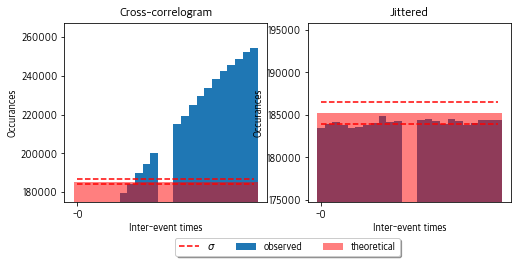

In [32]:
jitter_test(t1, t2, tj, win, delta, T_max)

## Bursty

In [13]:

def get_rates(t, interval_size, t_min, t_max):
    intervals = np.arange(t_min, t_max, interval_size)
    rates = []
    for i in range(len(intervals)-1):
        rates.append(len(t[(t>=intervals[i]) & (t<intervals[i+1])]) / interval_size)
    return intervals[:-1], np.array(rates)

    
def lambda_func(x, i__, r__):
    if x < win:
        return 0
    if x > (T-win):
        return 0
    else: 
        return r__[i__>=x][0]

def jitter_test(t1, t2, tj, win, delta, T, tag_A = "A", tag_B = "B", factor_red = 10, interval_size=1):

    fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(12,3.3))

    res = {}

    if type(t1) == list:
        t1 = np.array(t1)
    if type(t2)==list:
        t2 = np.array(t2)
    if type(tj)==list:
        tj = np.array(tj)


    t1 = t1[t1>=win]
    t1 = t1[t1<=T-win]

    bins= np.arange(-win,win+delta,delta)
    to_zero = np.where((bins == -delta))[0][0], np.where(bins==0)[0][0]


    deltas = []
    deltas_jitter = []
    for t in tqdm(np.array_split(t1, factor_red)): # auspol occurs 3.6 times more than the second most frequent - this is a safe value
        deltas.append(possible_time_del(t, t2, win, T))
        deltas_jitter.append(possible_time_del(t, tj, win, T))
    
    deltas = np.array(list(flatten(deltas)))
    deltas_jitter = np.array(list(flatten(deltas_jitter)))

    ylim=None
    return_H = True
    lab = True

    title = None


    H, bins = np.histogram(deltas, bins= np.arange(-win,win+delta,delta))

    Hr = H.copy()

    for ind in to_zero:
        H[ind] = 0
    
    axs[0].bar(bins[:-1], H, width=np.diff(bins), align='center', label='observed')

    # fit poisson ih
    lambda_1 = len(t1) / (T-2*win)
    lambda_2 = len(t2) / (T-2*win)

    # significance lines

    bins = np.arange(-win,win+delta,delta)
    b_heights = [expected_bin_height(x, lambda x : lambda_1,  lambda x : lambda_2, delta, win, T) for x in left_bin_edges(win, delta)]
    res['no_tod_lambdas'] = list(b_heights)
    axs[0].bar(bins[:-1], b_heights, width=np.diff(bins), align='center', label = 'theoretical', color='red', alpha=0.5)
    b_heights = np.array(b_heights)
    u = b_heights+3*np.sqrt(b_heights)
    l = b_heights-3*np.sqrt(b_heights)
    sns.lineplot(x=bins[:-1],y=b_heights+3*np.sqrt(b_heights), ax=axs[0],linestyle='--',color='red')
    sns.lineplot(x=bins[:-1], y=b_heights-3*np.sqrt(b_heights), ax=axs[0],linestyle='--',color='red', label = r'$\sigma$')

    axs[0].set_title(f'Cross-correlogram')#\nSignificance value: {np.sum([get_dist(lt,x,ut) for lt,x,ut in zip(l,H,u)]) / np.sum(H)}')

    # set y limits
    axs[0].set_ylim([np.max([0.95*np.min(b_heights-3*np.sqrt(b_heights)),0,0.95*np.min(H)]),1.05*np.max([np.max(H),np.max(b_heights+3*np.sqrt(b_heights))])])
    axs[2].set_ylim([np.max([0.95*np.min(b_heights-3*np.sqrt(b_heights)),0,0.95*np.min(H)]),1.05*np.max([np.max(H),np.max(b_heights+3*np.sqrt(b_heights))])])
    axs[0].set_xlabel('Inter-event times')
    
    ticks = np.arange(-win,win+delta, 60*30) # Now we know have many ticks you need
    labels = ["%.0f" % (x/(60)) for x in ticks] # Generate tick labels
    # xticks = ticks # and the actual positions of the ticks
    axs[0].set_xticks(ticks, labels=labels)
    axs[0].set_ylabel('Occurances')
    # ########################################



    H, bins = np.histogram(deltas_jitter, bins= np.arange(-win,win+delta,delta))

    for ind in to_zero:
        H[ind] = 0
    
    axs[1].bar(bins[:-1], H, width=np.diff(bins), align='center', label='observed')

    # significance lines

    axs[1].bar(bins[:-1], b_heights, width=np.diff(bins), align='center', label = 'theoretical', color='red', alpha=0.5)
    b_heights = np.array(b_heights)
    u = b_heights+3*np.sqrt(b_heights)
    l = b_heights-3*np.sqrt(b_heights)
    sns.lineplot(x=bins[:-1],y=b_heights+3*np.sqrt(b_heights), ax=axs[1],linestyle='--',color='red')
    sns.lineplot(x=bins[:-1], y=b_heights-3*np.sqrt(b_heights), ax=axs[1],linestyle='--',color='red', label = r'$\sigma$')

    axs[1].set_title(f'Jittered')#\nSignificance value: {np.sum([get_dist(lt,x,ut) for lt,x,ut in zip(l,H,u)]) / np.sum(H)}')

    # set y limits
    axs[1].set_ylim([np.max([0.95*np.min(b_heights-3*np.sqrt(b_heights)),0,0.95*np.min(H)]),1.05*np.max([np.max(H),np.max(b_heights+3*np.sqrt(b_heights))])])
    axs[1].set_xlabel('Inter-event times')
    
    ticks = np.arange(-win,win+delta, 60*30) # Now we know have many ticks you need
    labels = ["%.0f" % (x/(60)) for x in ticks] # Generate tick labels
    # xticks = ticks # and the actual positions of the ticks
    axs[1].set_xticks(ticks, labels=labels)
    axs[1].set_ylabel('Occurances')
    axs[1].legend(loc='upper center', bbox_to_anchor=(1.7, -0.17), shadow=True, ncol=3)

    axs[1].legend().set_visible(False)

    axs[0].legend(loc='upper center', bbox_to_anchor=(1.7, -0.17), shadow=True, ncol=3)


    i_s, r_s = get_rates(t1, interval_size, win,np.max([np.max(t1),T-win])+2*interval_size)
    i_t, r_t = get_rates(tj, interval_size, win, np.max([np.max(tj),T-win])+2*interval_size)

    lambda_s = lambda x : lambda_func(x, i_s, r_s)
    lambda_t = lambda x : lambda_func(x, i_t, r_t)


    res['jitter_h'] = list(H)


    H, bins = np.histogram(deltas, bins= np.arange(-win,win+delta,delta))
    axs[2].bar(bins[:-1], H, width=np.diff(bins), align='center')
    bins = np.arange(-win,win+delta,delta)
    b_heights_smooth = [expected_bin_height(x, lambda_s,  lambda_t, delta, win, T) for x in left_bin_edges(win, delta)]
    res['tod_lambdas'] = list(b_heights_smooth)
    axs[2].bar(bins[:-1], b_heights_smooth, width=np.diff(bins), align='center', color='red', alpha=0.5)
    # b_heights_smooth = b_heights_smooth[1:] + [b_heights_smooth[-1]]
    b_heights_smooth = np.array(b_heights_smooth)
    u = b_heights_smooth+3*np.sqrt(b_heights_smooth)
    l = b_heights_smooth-3*np.sqrt(b_heights_smooth)
    sns.lineplot(x=bins[:-1],y=b_heights_smooth+3*np.sqrt(b_heights_smooth), ax=axs[2],linestyle='--',color='red')
    sns.lineplot(x=bins[:-1], y=b_heights_smooth-3*np.sqrt(b_heights_smooth), ax=axs[2],linestyle='--',color='red')

    

    axs[2].set_title(f'Inhomogeneous null model')
    # set y limits
    # xticks = ticks # and the actual positions of the ticks
    axs[2].set_xticks(ticks, labels=labels, fontsize='small')

    axs[2].set_ylabel('Occurances')

    plt.savefig(f'{tag_A}_{tag_B}_jitter.pdf', bbox_inches='tight')
    # save res
    # res to dataframe
    # save res
    # pd.DataFrame(res).to_csv(f'{tag_A}_{tag_B}_bin_heights.csv', index=False)
    return True


In [14]:
# set up simulations for burstyness based on the spivakDeconvolutionImprovesDetection2022 paper

BR = 0.6 # this is the probability that an event is followed ny another spike within a uniform time interval of (l,u)
int_l = .01
int_u = .10

def bursty(lambda_t, BR, int_l, int_u, T):
    t_current = 0
    times = []
    while t_current < T:

        t_n = gen_poisson_homogeneous_single(lambda_t(t_current))
        t_current += t_n

        times = add_new_time(t_current, times, lambda_t, BR, int_l, int_u, T)

        t_current = times[-1]
    
    return times


def add_new_time(t_current, times, lambda_t, BR, int_l, int_u, T):

    times.append(t_current + gen_poisson_homogeneous_single(lambda_t(t_current)))

    u = np.random.rand()
    while u < BR:
        times.append(t_current + np.random.uniform(int_l, int_u))
        t_current = times[-1]
        u = np.random.rand()

        if t_current >= T:
            return times
        
    return times

In [15]:
def get_observed_bins(source,target,win,T,delta):
    '''
    delta = width of hist bin

    '''
    if type(source) == list:
        source = np.array(source)
    if type(target)==list:
        target = np.array(target)

    bins= np.arange(-win,win+delta,delta)
    to_zero = np.where((bins == -delta))[0][0], np.where(bins==0)[0][0]

    deltas = possible_time_del(source,target,win,T)
    # print('ob deltas')
    H, bins = np.histogram(deltas, bins= np.arange(-win,win+delta,delta))

    for ind in to_zero:
        H[ind] = 0

    return H

In [17]:
def jitter_times(t, interval_size, t_min, t_max):
    intervals = np.arange(t_min, t_max, interval_size)
    jittered_times = []
    for i in range(len(intervals)-1):
        jittered_times.append(intervals[i] + np.random.rand(len(t[(t>=intervals[i]) & (t<intervals[i+1])]))*interval_size)

    jittered_times.append(intervals[-1] + np.random.rand(len(t[(t>=intervals[-1])]))*interval_size)

    return np.array(list(flatten(jittered_times)))

In [18]:
c1 = 2
c2 = 2

int_l = 0.001
int_u = 0.02

BR = 0.8

T = 1000

interval_size = 20
t_min = 0


lambda_s_bursty = lambda t: c1
lambda_t_bursty = lambda t: c2

t1 = np.array(bursty(lambda_t_bursty, BR, int_l, int_u, T))
t2 = np.array(bursty(lambda_s_bursty, BR, int_l, int_u, T))

t1 = t1[t1<=T]
t2 = t2[t2<=T]

tj = jitter_times(t2, interval_size, t_min, T)

In [19]:
win = 6
delta = 0.25
T_max = T

In [20]:
len(t1), len(t2), len(tj)

(7492, 7837, 7837)

  0%|          | 0/10 [00:00<?, ?it/s]

/var/folders/wp/758jq81s3hs0jlp8_31261sc0000gn/T/ipykernel_98932/2777683728.py:39: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(term, w, T-w)[0] # integral from si+hj to si+hj+delta of lambda_S * E[events from T]


True

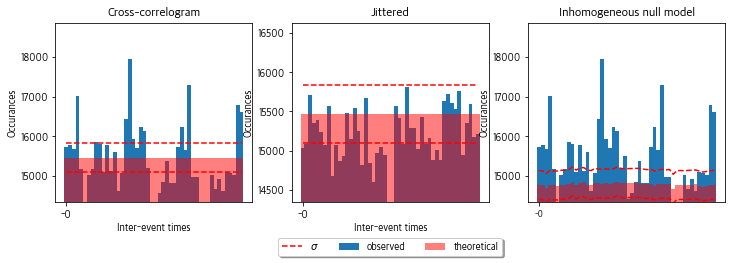

In [325]:
jitter_test(t1, t2, tj, win, delta, T_max, interval_size=3)

## Error with sinudoidal functions

In [21]:
"""
Preamble for most code and jupyter notebooks
@author: bridgetsmart
@notebook date: 26 Mar 2024
"""

import numpy as np, pandas as pd

import matplotlib.pyplot as plt, seaborn as sns
import matplotlib as mpl

import math, string, re, pickle, json, time, os, sys, datetime, itertools

from tqdm.notebook import tqdm

import scipy
from cross_correlogram import *
from simulating_hawkes import *

# circadian / time of day effect

from scipy.optimize import curve_fit

import scipy.integrate as integrate
def expected_target_events_hj_delta(si, hj, delta, lambda_T):
    l= si + hj
    return integrate.quad(lambda_T, l, l+delta)[0] # integral from si+hj to si+hj+delta of lambda_T

def expected_bin_height(hj, lambda_S, lambda_T, delta, w, T):
    term = lambda x : lambda_S(x) * expected_target_events_hj_delta(x, hj, delta, lambda_T)
    return integrate.quad(term, w, T-w)[0] # integral from si+hj to si+hj+delta of lambda_S * E[events from T]

def sd_bin_height(hj, lambda_S, lambda_T, delta, w, T):
    term = lambda x : lambda_S(x) * expected_target_events_hj_delta(x, hj, delta, lambda_T)
    return integrate.quad(term, w, T-w)[0] # integral from si+hj to si+hj+delta of lambda_S * E[events from T]
## simulation to test error in mean averaging


def get_observed_bins(source,target,win,T,delta):
    '''
    delta = width of hist bin

    '''
    if type(source) == list:
        source = np.array(source)
    if type(target)==list:
        target = np.array(target)

    bins= np.arange(-win,win+delta,delta)
    to_zero = np.where((bins == -delta))[0][0], np.where(bins==0)[0][0]

    deltas = possible_time_del(source,target,win,T)
    # print('ob deltas')
    H, bins = np.histogram(deltas, bins= np.arange(-win,win+delta,delta))

    for ind in to_zero:
        H[ind] = 0

    return H

In [36]:
# look at error as a function of k

## PARAMETERS
c1 = 1
c2 = 1

k = 10

int_l = 1
int_u = 10

T = 100000

lambda_s_bursty = lambda t: c1
lambda_t_bursty = lambda t: c2

n_iter = 1000

Delta = 0.25 # bin size of 15 minutes
w= 3 # width of cross correlogram (i.e. 3 hours)

# get expected bin heights for source and target intensities WITHOUT jitter
bins = np.arange(-w,w+Delta,Delta)

errors_BR = []
BR_s = []
true_bin_heights_list = []
observed_bin_heights_list = []
observed_bin_heights_jitter_list = []
b_heights_smooth_list = []

interval_size = 10

### SAMPLING
for BR in tqdm(np.arange(0,1,0.01)):
    # for _ in range(n_iter):
    BR_s.append(BR)

    delta = k * Delta

    t1 = np.array(bursty(lambda_t_bursty, BR, int_l, int_u, T))
    t2 = np.array(bursty(lambda_s_bursty, BR, int_l, int_u, T))

    true_bin_heights = np.array([expected_bin_height(x, lambda_s, lambda_t, Delta, w, T) for x in left_bin_edges(w, Delta)])

    observed_bin_heights = get_observed_bins(t1,t2,w,T,Delta) 

    tj = jitter_times(t2, interval_size, 0, T)

    observed_bin_heights_jitter = get_observed_bins(t1,np.array(tj),w,T,Delta)

    i_s, r_s = get_rates(t1, interval_size, win,np.max([np.max(t1),T-win])+2*interval_size)
    i_t, r_t = get_rates(t2, interval_size, win, np.max([np.max(t2),T-win])+2*interval_size)

    lambda_s2 = lambda x : lambda_func(x, i_s, r_s)
    lambda_t2 = lambda x : lambda_func(x, i_t, r_t)
    b_heights_smooth = [expected_bin_height(x, lambda_s2,  lambda_t2, delta, win, T) for x in left_bin_edges(win, delta)]

    errors_BR.append(np.sum((observed_bin_heights-observed_bin_heights_jitter)**2))
    true_bin_heights_list.append(true_bin_heights)
    observed_bin_heights_list.append(observed_bin_heights)
    observed_bin_heights_jitter_list.append(observed_bin_heights_jitter)
    b_heights_smooth_list.append(b_heights_smooth)


  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/wp/758jq81s3hs0jlp8_31261sc0000gn/T/ipykernel_28502/1803679450.py:31: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(term, w, T-w)[0] # integral from si+hj to si+hj+delta of lambda_S * E[events from T]


In [29]:
# make plot showing jitter, null and smooth null



(array([   6.,   16.,   26.,   36.,   46.,   56.,   66.,   76.,   86.,
          96.,  106.,  116.,  126.,  136.,  146.,  156.,  166.,  176.,
         186.,  196.,  206.,  216.,  226.,  236.,  246.,  256.,  266.,
         276.,  286.,  296.,  306.,  316.,  326.,  336.,  346.,  356.,
         366.,  376.,  386.,  396.,  406.,  416.,  426.,  436.,  446.,
         456.,  466.,  476.,  486.,  496.,  506.,  516.,  526.,  536.,
         546.,  556.,  566.,  576.,  586.,  596.,  606.,  616.,  626.,
         636.,  646.,  656.,  666.,  676.,  686.,  696.,  706.,  716.,
         726.,  736.,  746.,  756.,  766.,  776.,  786.,  796.,  806.,
         816.,  826.,  836.,  846.,  856.,  866.,  876.,  886.,  896.,
         906.,  916.,  926.,  936.,  946.,  956.,  966.,  976.,  986.,
         996., 1006.]),
 array([0.3, 0.8, 0.6, 0.4, 0.6, 0.8, 0.3, 0.6, 0.4, 0.5, 0.3, 0.3, 0.5,
        0.4, 0.5, 0.6, 0.5, 0.3, 0.5, 0.3, 0.4, 0.4, 0.3, 0.7, 0.2, 0.5,
        0.5, 0.5, 0.2, 0.4, 0.3, 0.4, 0.6, 0.7, 0